In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import chromATAC as ca
from chromATAC.integrated import IntData
from functools import reduce
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.colors as mcolors
from tqdm import tqdm
import warnings
import seaborn as sns
import matplotlib.gridspec as gridspec
from scipy.cluster import hierarchy

warnings.simplefilter("ignore", category=pd.errors.ParserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [21]:
tes_dir = '/Users/mossishahi/Code/lupien/IntData/data/V2-TEs/TEs/'
cotes_dir = '/Users/mossishahi/Code/lupien/IntData/data/V2-TEs/CoTEs/'

In [22]:
TEs = np.array([i.split('.')[0] for i in os.listdir(tes_dir) if i.endswith('.bed')])
COTEs = np.array([i.split('.')[0] for i in os.listdir(cotes_dir) if i.endswith('.bed')])

In [24]:
te_meta = pd.read_csv('/Users/mossishahi/Code/lupien/IntData/analysis/data/repeat_metadata.onlyTEs_full.tsv', sep='\t')
te_df = te_meta.iloc[np.concatenate([np.where(te_meta['repname_numbered'].apply(lambda x: i.split('_')[0]==x.split('_')[0]))[0] for i in TEs]), :].loc[:, ['repname', 'Superfamily', 'repname_numbered']].copy()
te_df.index = range(1, len(te_df)+1)
te_df['COTE'] = te_df['repname_numbered'].apply(lambda x: x.split('_')[0] in np.array([i.split('_')[0] for i in np.intersect1d(TEs, COTEs)]))
te_df.loc[971] = ['ERV3-16A3_I-int', 'ERVL', '369_ERV3-16A3_I-int', True]

In [25]:
te_n_elements = pd.read_csv(tes_dir+'/n_elements_per_TE.tsv', sep='\t', header=None, names = ['name', 'n_elements'])
cote_n_elments = pd.read_csv(cotes_dir+'/n_clusters_per_TE.tsv', sep='\t', header=None, names = ['name', 'n_clusters'])

In [26]:
te_n_elements['name'] = te_n_elements['name'].apply(lambda x: x.split('_Merged.bed')[0])
cote_n_elments['name'] = cote_n_elments['name'].apply(lambda x: x.split('_Merged.bed')[0])
te_df = te_df.merge(te_n_elements, how='left', left_on='repname_numbered', right_on='name').merge(cote_n_elments, how='left', left_on='repname_numbered', right_on='name').drop(['name_x', 'name_y'], axis=1).fillna(0)
te_df.set_index('repname_numbered', inplace=True)

-------

## CNV and CoTEs

In [27]:
chroms = ca.info.CHROMOSOMES['names']

In [28]:
df = pd.read_csv('/Users/mossishahi/Code/lupien/IntData/analysis/experiment15/loss/chr1__pval_n_hit.csv', index_col=False)
df = df.rename(columns={'Unnamed: 0': 'CoTE'})
df = df.set_index('CoTE')

In [29]:
pd.DataFrame([i.split('>')[-1] for i in df.columns]).to_csv('CancerTypes.csv', index=False)

In [30]:
cnv_meta = pd.read_csv("/Users/mossishahi/Code/lupien/IntData/data/CNVAR/summary.ascatv3TCGA.penalty70.hg38.tsv", sep='\t')

In [31]:
parent_dir = '/Users/mossishahi/Code/lupien/IntData/'

In [ ]:
fig, axs = plt.subplots(4, 6, figsize=(25, 45), sharey=True)
for i, c in enumerate(chroms[:-1]):
    df = pd.read_csv(f'/cluster/home/t124771uhn/analysis/experiment11/loss/{c}__n_hits.csv', index_col=False)
    df = df.rename(columns={'Unnamed: 0': 'CoTE'})
    df = df.set_index('CoTE')
    sns.boxplot(df, orient='h', showfliers=True, ax=axs.flatten()[i], flierprops=dict(marker='o', markersize=0.5, linestyle='none', markeredgecolor='grey'))
    axs.flatten()[i].set_title(f'{c}')
    # sns.stripplot(df, orient='h', jitter=True, ax=axs.flatten()[i], color='grey')
fig.savefig('chr1_n_hits.png', dpi=600, bbox_inches='tight')
plt.show()

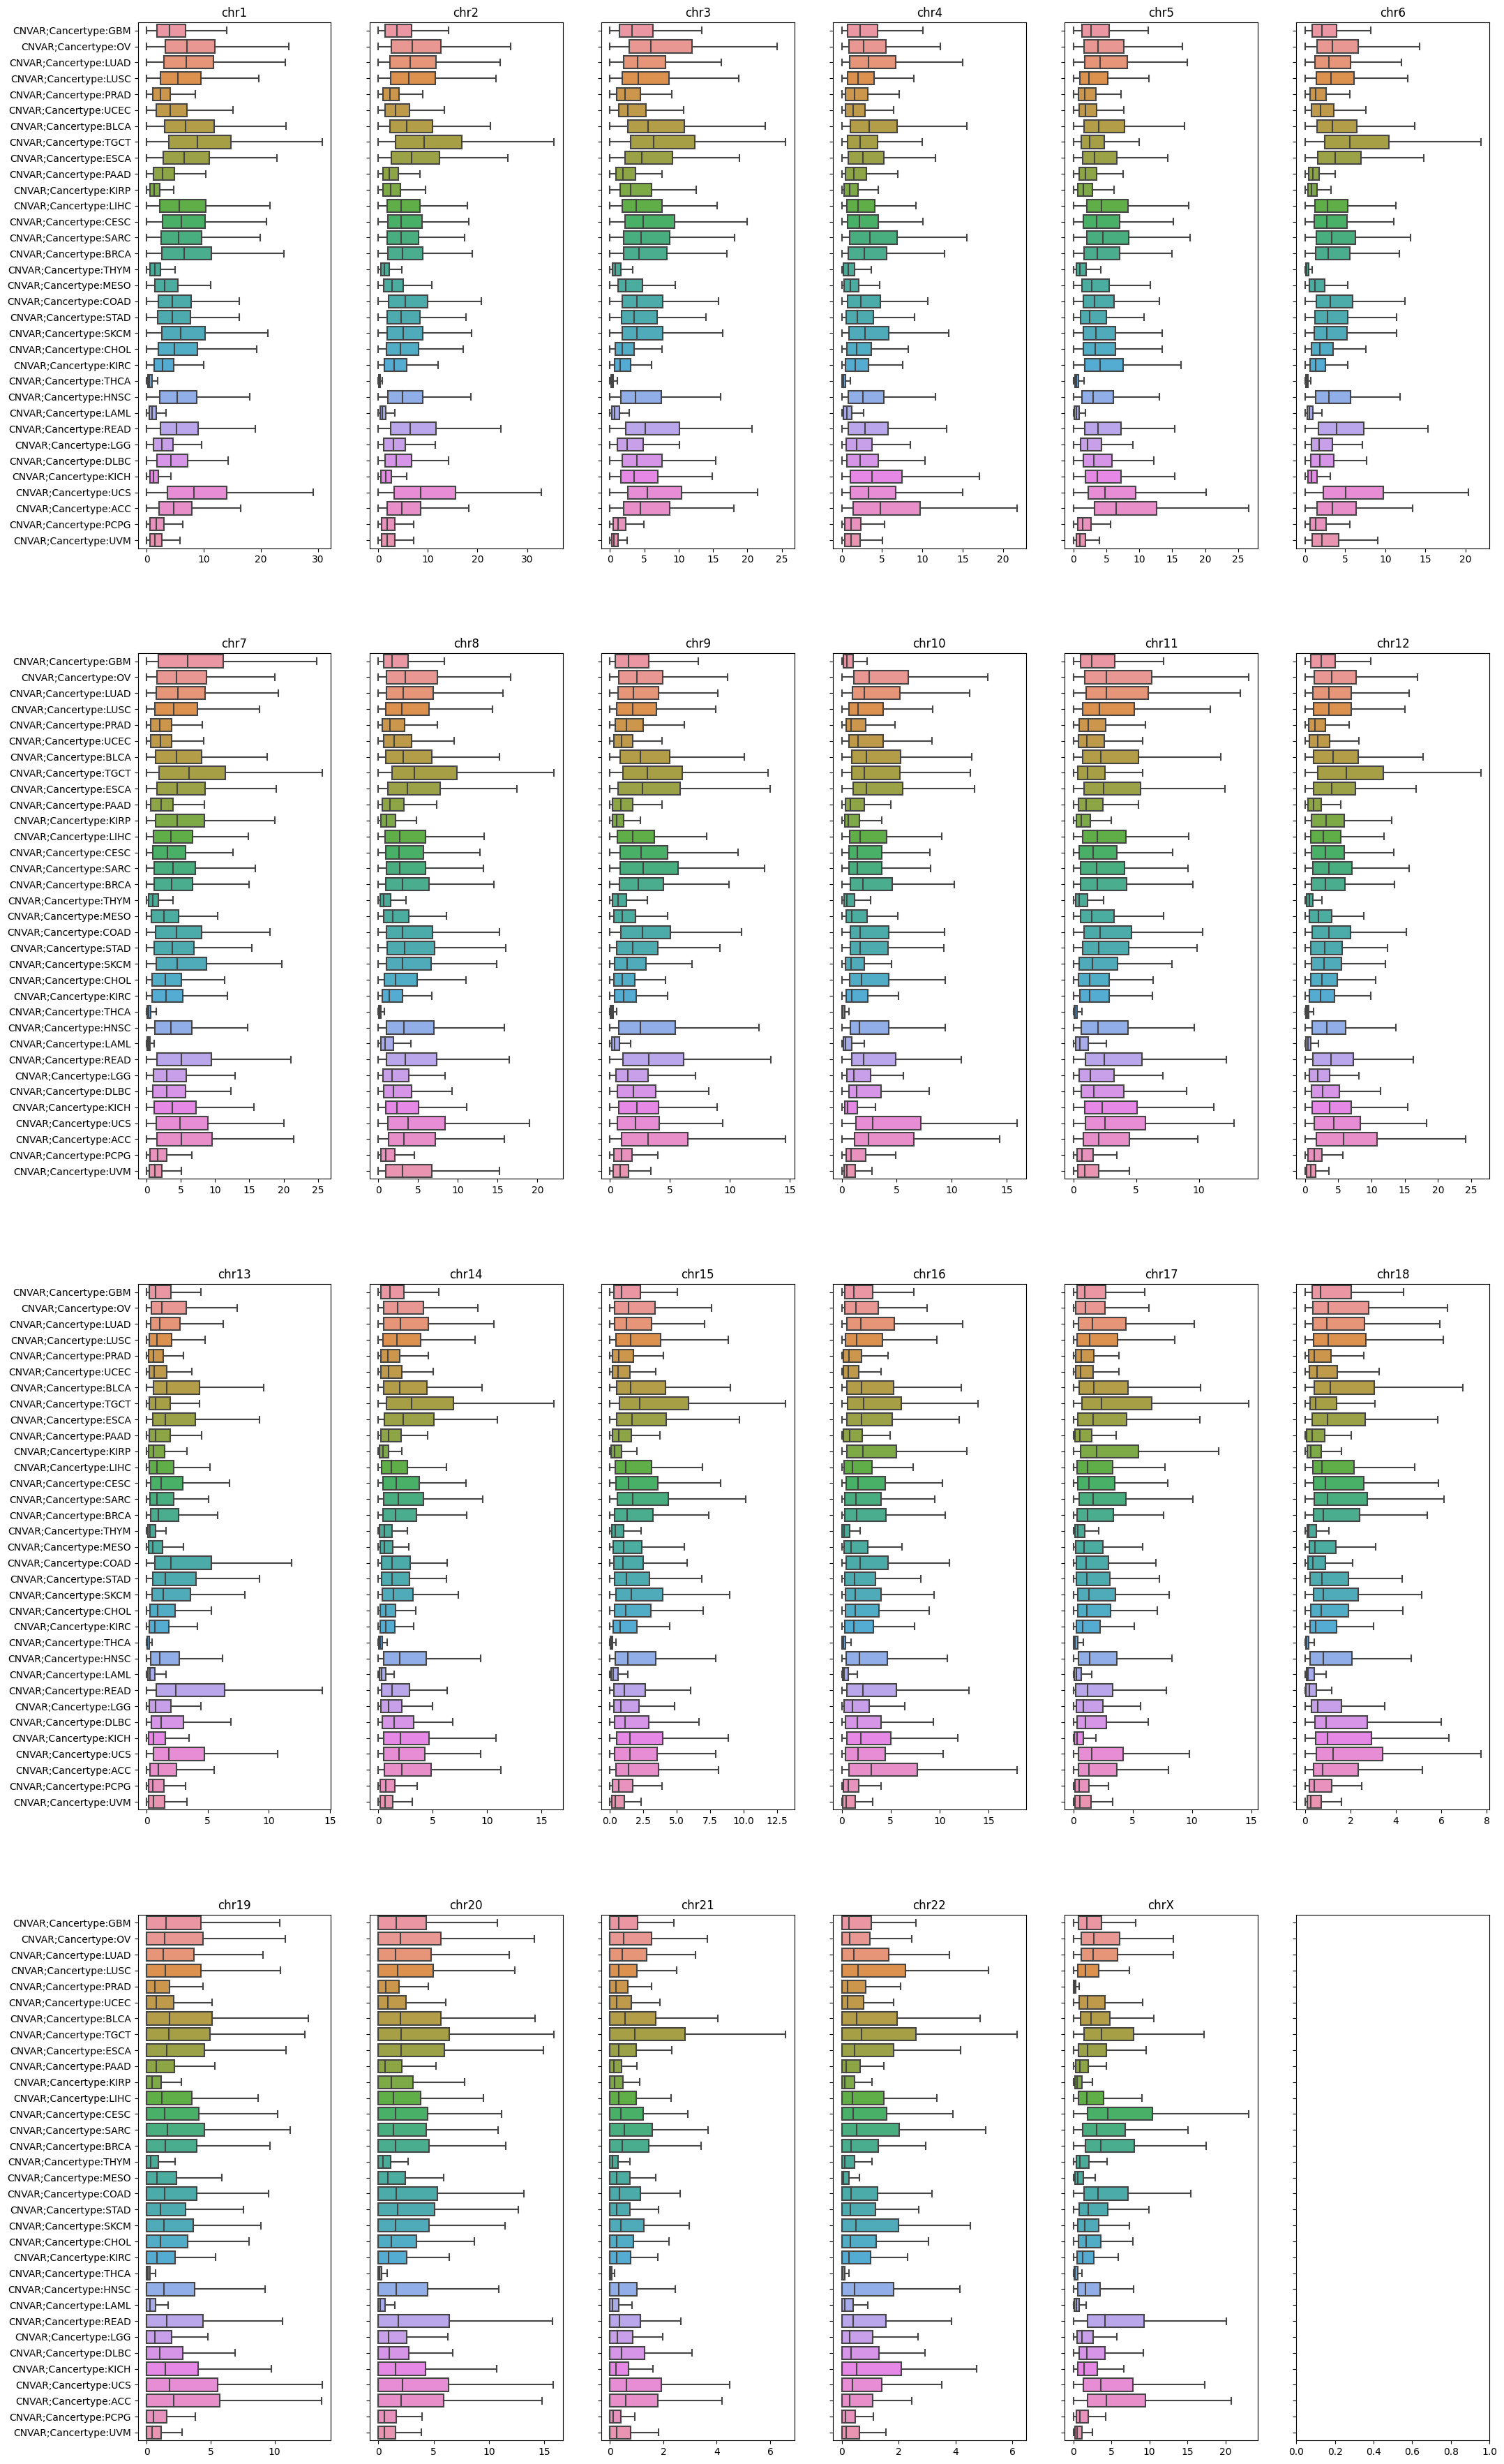

In [47]:
fig, axs = plt.subplots(4, 6, figsize=(25, 45), sharey=True)
for i, c in enumerate(chroms[:-1]):
    df = pd.read_csv(f'/cluster/home/t124771uhn/analysis/experiment11/gain/{c}__n_hits.csv', index_col=False)
    df = df.rename(columns={'Unnamed: 0': 'CoTE'})
    df = df.set_index('CoTE')
    sns.boxplot(df, orient='h', showfliers=False, ax=axs.flatten()[i])
    axs.flatten()[i].set_title(f'{c}')
    # sns.stripplot(df, orient='h', jitter=True, ax=axs.flatten()[i], color='grey')
plt.show()

In [12]:
def preprocess_data(file_path):
    df = pd.read_csv(file_path, index_col=False)
    df = df.rename(columns={'Unnamed: 0': 'CoTE'})
    df['CoTE'] = df['CoTE'].apply(lambda x: '_'.join(x.split('>')[-1].split('_')[1:]))
    df.rename({i: i.split(':')[-1] for i in df.columns}, axis=1, inplace=True)
    df = df.set_index('CoTE')
    return df
def adjust_tables(df_gain, df_loss):
    gc = list(set(list(df_gain.columns)) - set(list(df_loss.columns)))
    for c in gc:
        df_loss[c]=1
    lc = list(set(list(df_loss.columns)) - set(list(df_gain.columns)))
    for c in gc:
        df_gain[c]=1
    
def lg_heatmap(c = 'chr8', orient='h'):
    df_gain = pd.read_csv(f'/cluster/home/t124771uhn/analysis/experiment11/gain/{c}__qval_n_hit.csv', index_col=False)
    df_gain = df_gain.rename(columns={'Unnamed: 0': 'CoTE'})
    df_gain['CoTE'] = df_gain['CoTE'].apply(lambda x: '_'.join(x.split('>')[-1].split('_')[1:]))
    df_gain.rename({i:i.split(':')[-1] for i in df_gain.columns}, axis=1, inplace=True)
    df_gain = df_gain.set_index('CoTE')
    
    df_loss = pd.read_csv(f'/cluster/home/t124771uhn/analysis/experiment11/loss/{c}__qval_n_hit.csv', index_col=False)
    df_loss = df_loss.rename(columns={'Unnamed: 0': 'CoTE'})
    df_loss['CoTE'] = df_loss['CoTE'].apply(lambda x: '_'.join(x.split('>')[-1].split('_')[1:]))
    df_loss.rename({i:i.split(':')[-1] for i in df_loss.columns}, axis=1, inplace=True)
    df_loss = df_loss.set_index('CoTE')
    adjust_tables(df_gain, df_loss)
    row_linkage = hierarchy.linkage(df_gain, method='average')
    col_linkage = hierarchy.linkage(df_gain.T, method='average')
    row_order = hierarchy.leaves_list(row_linkage)
    col_order = hierarchy.leaves_list(col_linkage)
    # plt.show()
    vmin = 0
    vmax = 1
    fig, axs = plt.subplots(2, 1, figsize=(50, 10), sharex=True)
    plt.suptitle(f'Copy Number Variation in different Cancer types vs Prescence/Abscence of CoTE in Mbp of {c}', fontsize=16 ,ha='center', y=1.02)
    sns.heatmap(df_gain.iloc[row_order, col_order] if orient=='v' else df_gain.T.iloc[col_order, row_order], square=True, ax=axs.flatten()[0], cbar=False, vmin=vmin, vmax=vmax)
    axs.flatten()[0].set_title('CNV Gain Locus', fontsize=16, pad=20)
    sns.heatmap(df_loss.iloc[row_order, col_order] if orient=='v' else df_loss.T.iloc[col_order, row_order], square=True, ax=axs.flatten()[1], cbar=False, vmin=vmin, vmax=vmax)
    axs.flatten()[1].set_title('CNV Loss Locus', fontsize=16, pad=20)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    # plt.subplots_adjust(left=0.15)  # Adjust as needed
    plt.subplots_adjust(left=0.15, top=.75, hspace=0.3)
    plt.show()
    return df_gain, df_loss

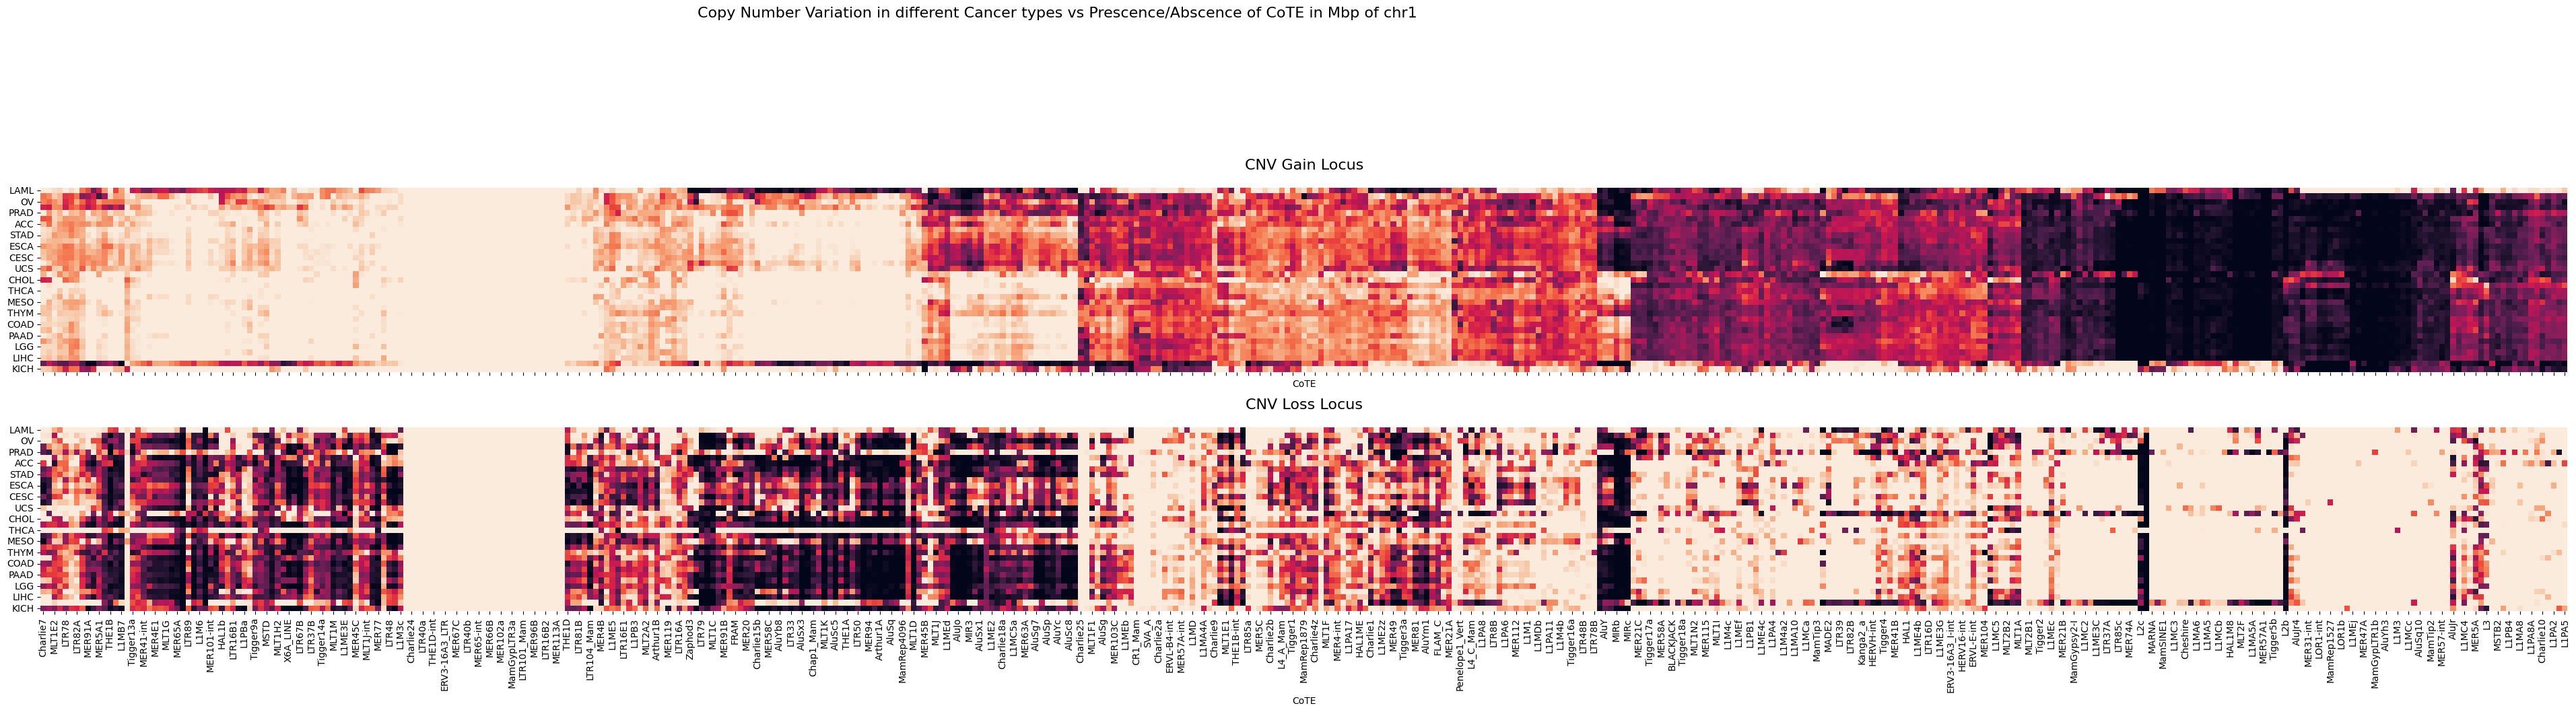

In [13]:
df_gain, df_loss = lg_heatmap('chr1')

In [61]:
c = 'chr7'
CT = 'GBM'
df = pd.read_csv(f'/Users/mossishahi/Code/lupien/IntData/analysis/experiment20/gain/{c}__n_hits.csv')
df.rename(columns={
    'Unnamed: 0': 'Subfamily'
}, inplace=True)

In [62]:
df.sort_values(by=f'CNVAR;Cancertype:{CT}', ascending=False)

Subfamily  CNVAR;Cancertype:GBM  \
229           COTEs;COTEs>1079_MER6A             33.885763   
217           COTEs;COTEs>1010_MER4D             31.551633   
190            COTEs;COTEs>755_LTR32             23.739665   
304        COTEs;COTEs>307_Charlie24             23.026042   
269            COTEs;COTEs>970_MER34             20.217591   
..                               ...                   ...   
372        COTEs;COTEs>1210_MSTA-int              0.000000   
426       COTEs;COTEs>661_LTR101_Mam              0.000000   
204          COTEs;COTEs>1114_MER90a              0.000000   
200  COTEs;COTEs>465_Helitron3Na_Mam              0.000000   
452       COTEs;COTEs>1367_THE1D-int              0.000000   

     CNVAR;Cancertype:OV  CNVAR;Cancertype:LUAD  CNVAR;Cancertype:LUSC  \
229            20.470923              32.149934              24.017954   
217            21.056447              25.915813              21.279237   
190            16.229260              19.535288              16.089240   
304            19.385930              17.413978              14.438868   
269            17.631732              15.486486              12.539497   
..                   ...                    ...                    ...   
372             0.000000               0.000000               0.000000   
426             0.000000               0.000000               0.000000   
204             0.000000               0.000000               0.000000   
200             0.000000               0.000000               0.000000   
452             0.000000               0.000000               0.000000   

     CNVAR;Cancertype:PRAD  CNVAR;Cancertype:UCEC  CNVAR;Cancertype:BLCA  \
229              11.491702              10.238497              28.399766   
217               9.892920               9.305094              23.352826   
190               7.822262               7.332107              17.591119   
304               7.094420               6.614939              15.706633   
269               6.359001               5.844777              13.741451   
..                     ...                    ...                    ...   
372               0.000000               0.000000               0.000000   
426               0.000000               0.000000               0.000000   
204               0.000000               0.000000               0.000000   
200               0.000000               0.000000               0.000000   
452               0.000000               0.000000               0.000000   

     CNVAR;Cancertype:TGCT  CNVAR;Cancertype:ESCA  ...  CNVAR;Cancertype:HNSC  \
229              39.344799              32.541897  ...              23.488458   
217              33.919721              26.224607  ...              19.364969   
190              26.499161              19.969786  ...              14.122851   
304              22.815953              12.597535  ...              10.754420   
269              19.599492              10.982231  ...               9.339564   
..                     ...                    ...  ...                    ...   
372               0.000000               0.000000  ...               0.000000   
426               0.000000               0.000000  ...               0.000000   
204               0.000000               0.000000  ...               0.000000   
200               0.000000               0.000000  ...               0.000000   
452               0.000000               0.000000  ...               0.000000   

     CNVAR;Cancertype:LAML  CNVAR;Cancertype:READ  CNVAR;Cancertype:LGG  \
229               1.420290              33.358115             15.954743   
217               1.302676              27.845148             14.687760   
190               0.984375              21.141953             11.032816   
304               0.882943              19.315737             13.046323   
269               0.746181              17.002120             11.371066   
..                     ...                    ...        

In [63]:
qv_df = pd.read_csv(f'/Users/mossishahi/Code/lupien/IntData/analysis/experiment20/gain/{c}__qval_n_hit.csv')
qv_df.rename(columns={
    'Unnamed: 0': 'Subfamily'
}, inplace=True)

In [70]:
df = df.loc[:, ['Subfamily', f'CNVAR;Cancertype:{CT}']].merge(qv_df.loc[:, ['Subfamily', f'CNVAR;Cancertype:{CT}']], on='Subfamily')

In [77]:
df = df[df[f'CNVAR;Cancertype:{CT}_y']<=0.05]

In [81]:
df.sort_values(by=f'CNVAR;Cancertype:{CT}_x', ascending=False).head(20)

Subfamily  CNVAR;Cancertype:GBM_x  CNVAR;Cancertype:GBM_y
409    COTEs;COTEs>1009_MER4D1               17.584228                0.000000
368      COTEs;COTEs>569_L1MCb               14.150294                0.000000
58   COTEs;COTEs>287_Charlie10               13.412615                0.000000
180    COTEs;COTEs>1002_MER4A1               12.318028                0.000000
433      COTEs;COTEs>813_LTR56               12.080100                0.000000
341     COTEs;COTEs>964_MER31B                5.636866                0.000000
164      COTEs;COTEs>782_LTR41                5.261049                0.000000
189      COTEs;COTEs>568_L1MCa                2.694925                0.000000
57      COTEs;COTEs>129_AluYk3                2.461717                0.000000
195     COTEs;COTEs>117_AluYf1                1.563773                0.006743
351      COTEs;COTEs>456_HAL1b                1.487928                0.000000
256      COTEs;COTEs>596_L1MEc                1.304645                0.000000
343      COTEs;COTEs>597_L1MEd                0.980248                0.000000
435  COTEs;COTEs>1013_MER4-int                0.978948                0.000000
390      COTEs;COTEs>598_L1MEf                0.957787                0.000000
297      COTEs;COTEs>91_AluSc8                0.682042                0.023672
276       COTEs;COTEs>536_L1M5                0.493283                0.000000

In [59]:
# sdf.index.name = 'pvalue'

/tmp/ipykernel_375/889355042.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
/tmp/ipykernel_375/889355042.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
/tmp/ipykernel_375/889355042.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)


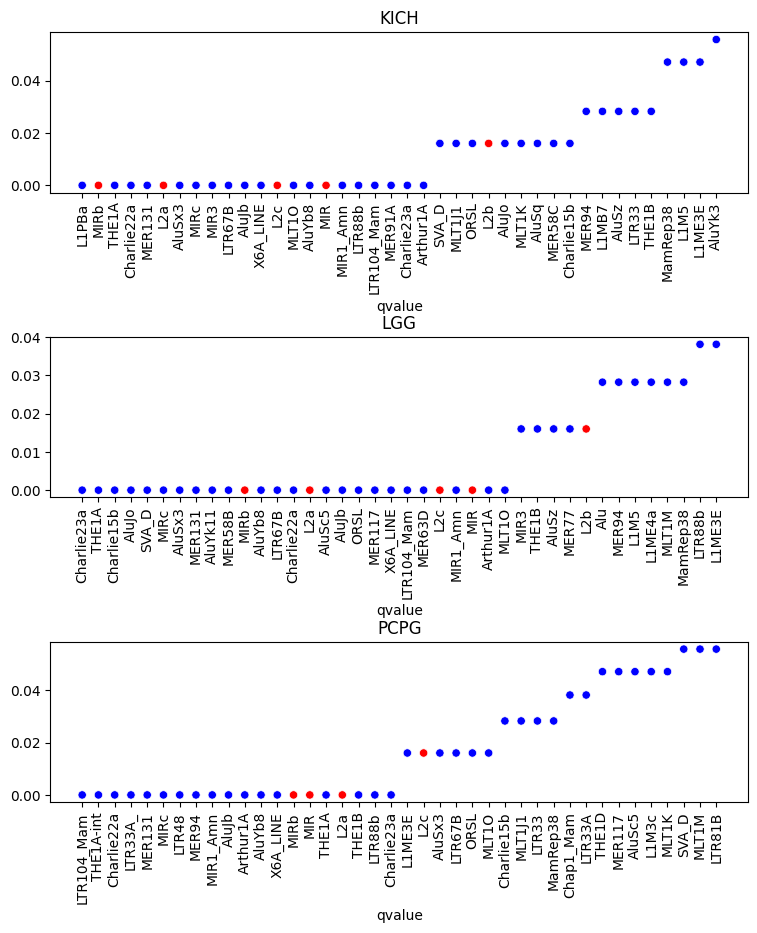

In [120]:
fig, axs = plt.subplots(3, 1, figsize=(9, 10), )
plt.xticks(rotation=90)
for i, ct in enumerate(['KICH', 'LGG', 'PCPG']):
    # Now plot using these colors
    sdf = df_loss[ct].sort_values(ascending=True).iloc[:40, ]
    sdf.index.name='qvalue'
    hue_colors = ['red' if v in ['L2a', 'L2c', 'MIR', 'L2b', 'MIRb'] else 'blue' for v in sdf.index]
    # Create the scatterplot with hue set to your list of colors
    sns.scatterplot(x=sdf.index, y=sdf.values, hue=hue_colors, palette=['blue', 'red'], legend=False, ax=axs.flatten()[i])
    axs.flatten()[i].set_title(ct)
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
fig.subplots_adjust(hspace=.9)  # Adjust the amount of width space between subplots
fig.savefig('pval_valid.png', bbox_inches='tight', dpi=600)
plt.show()

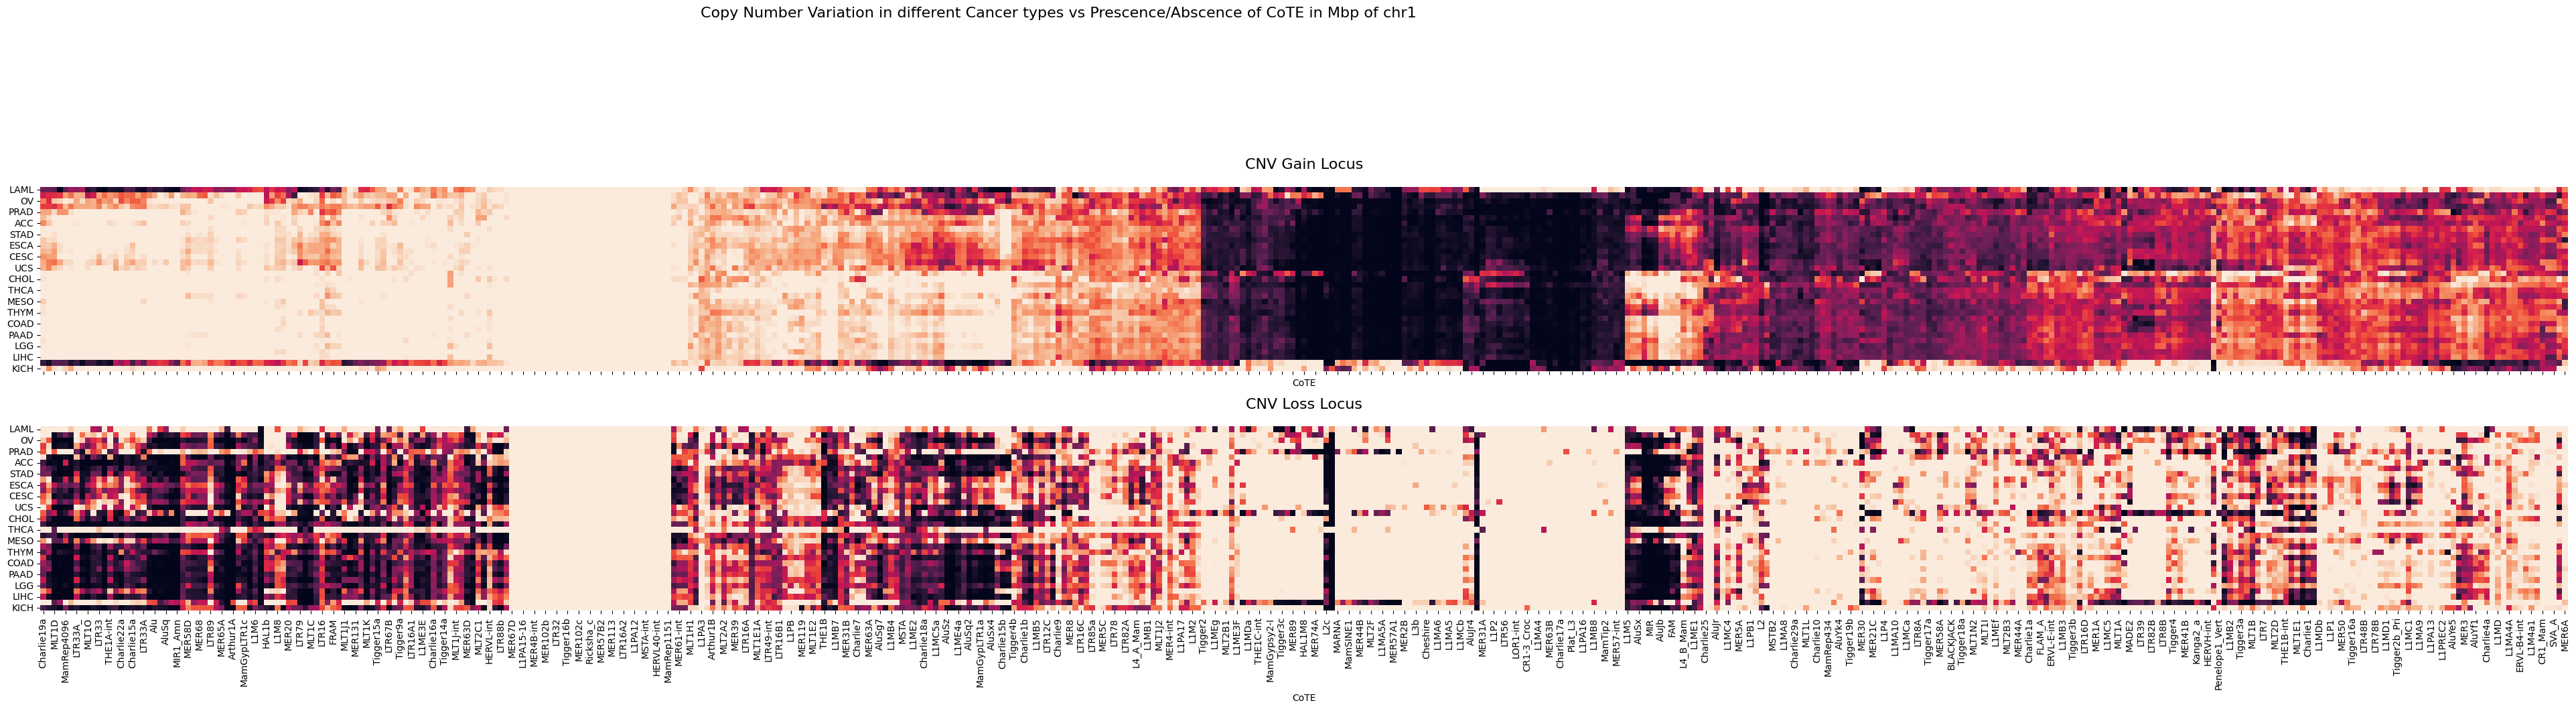

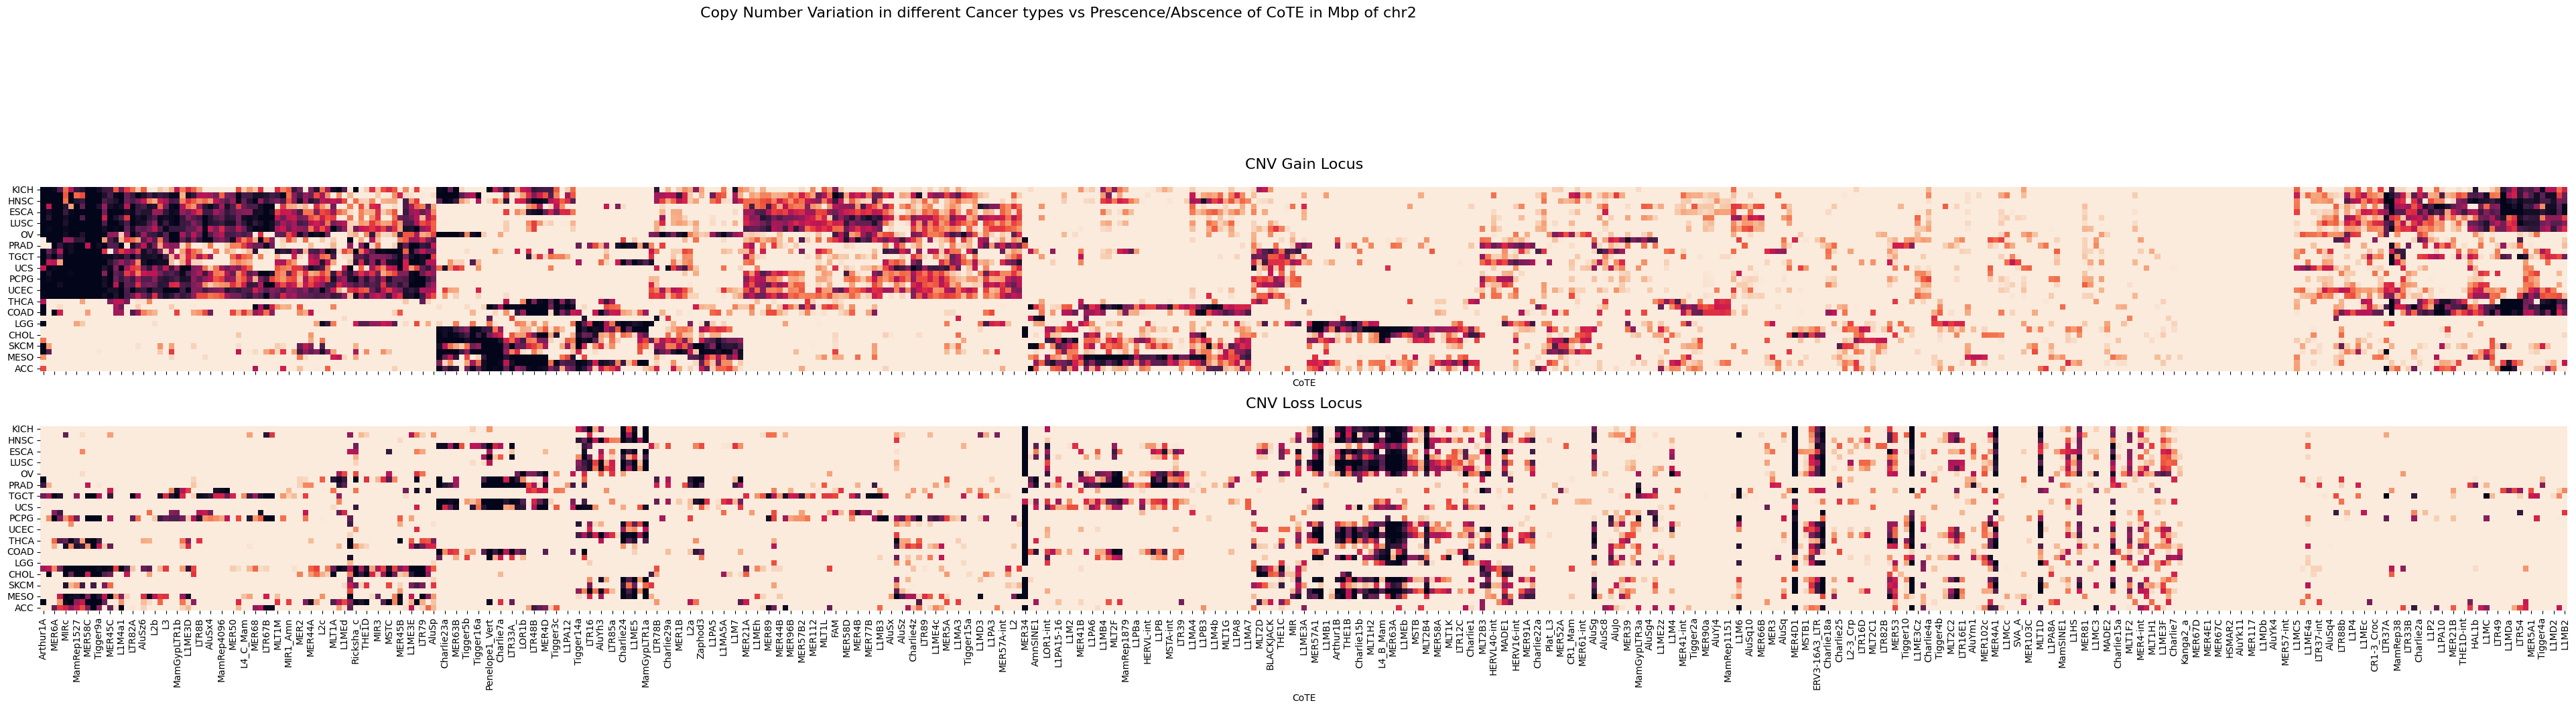

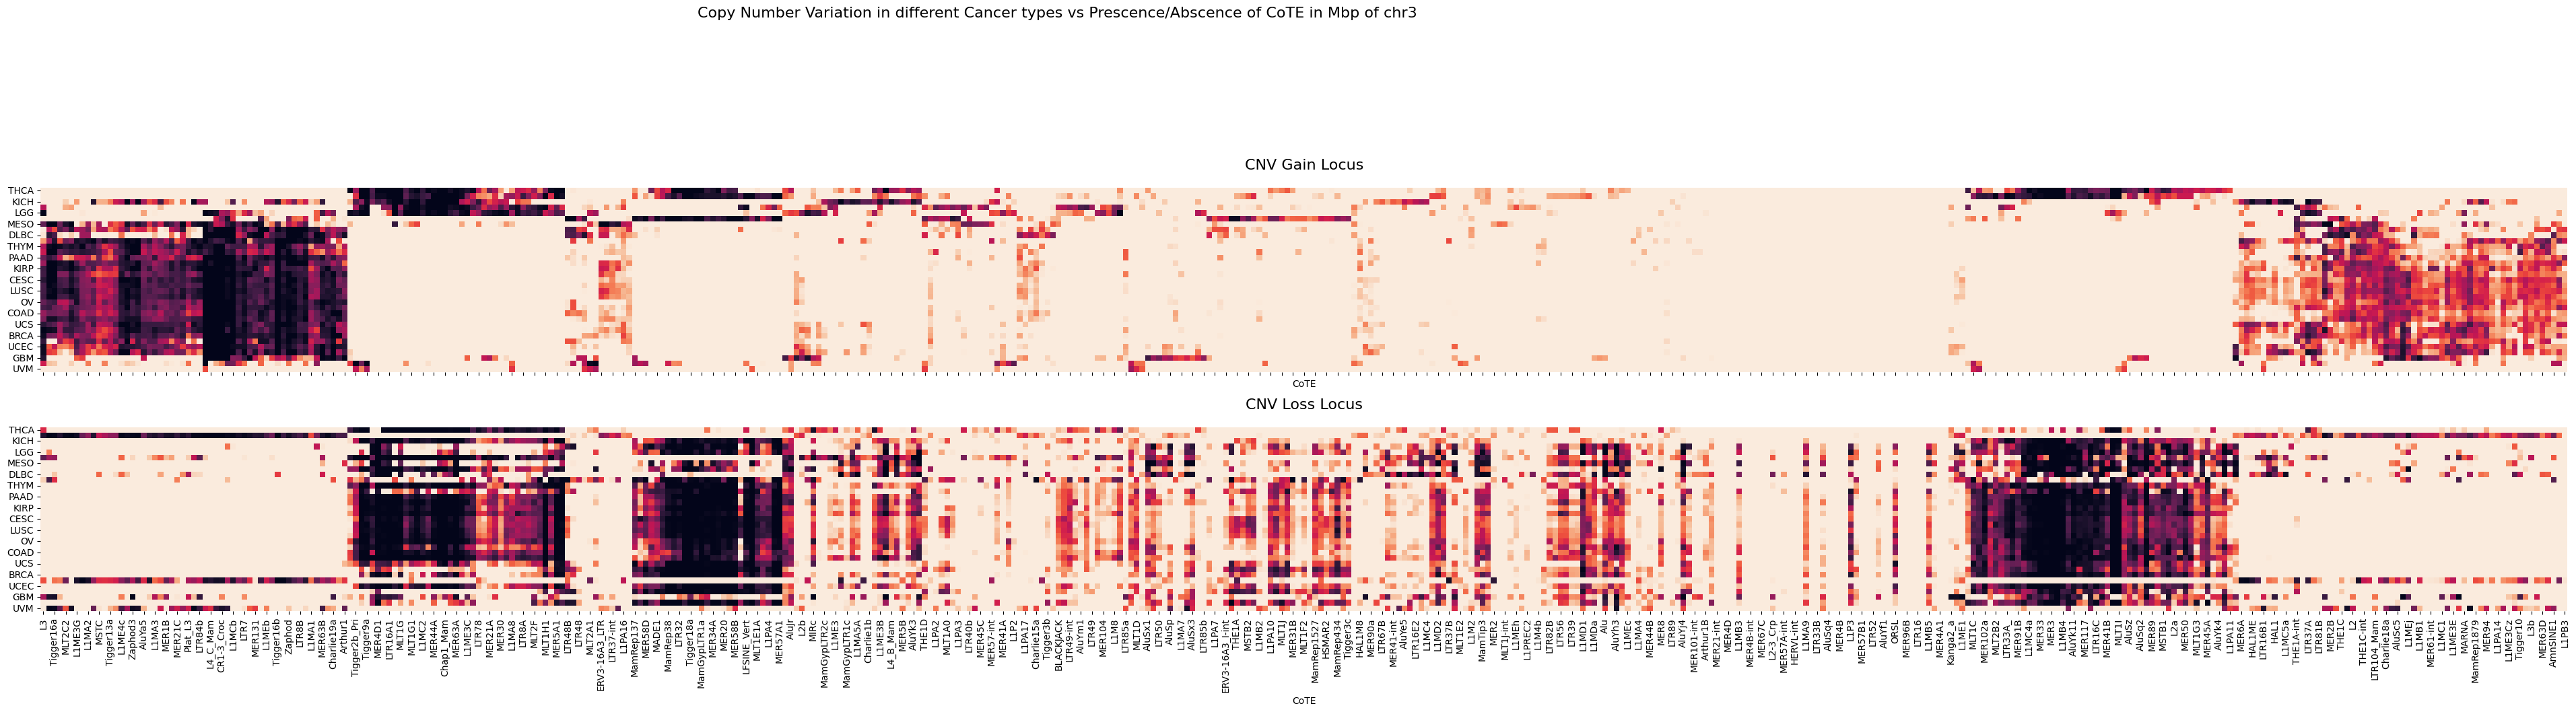

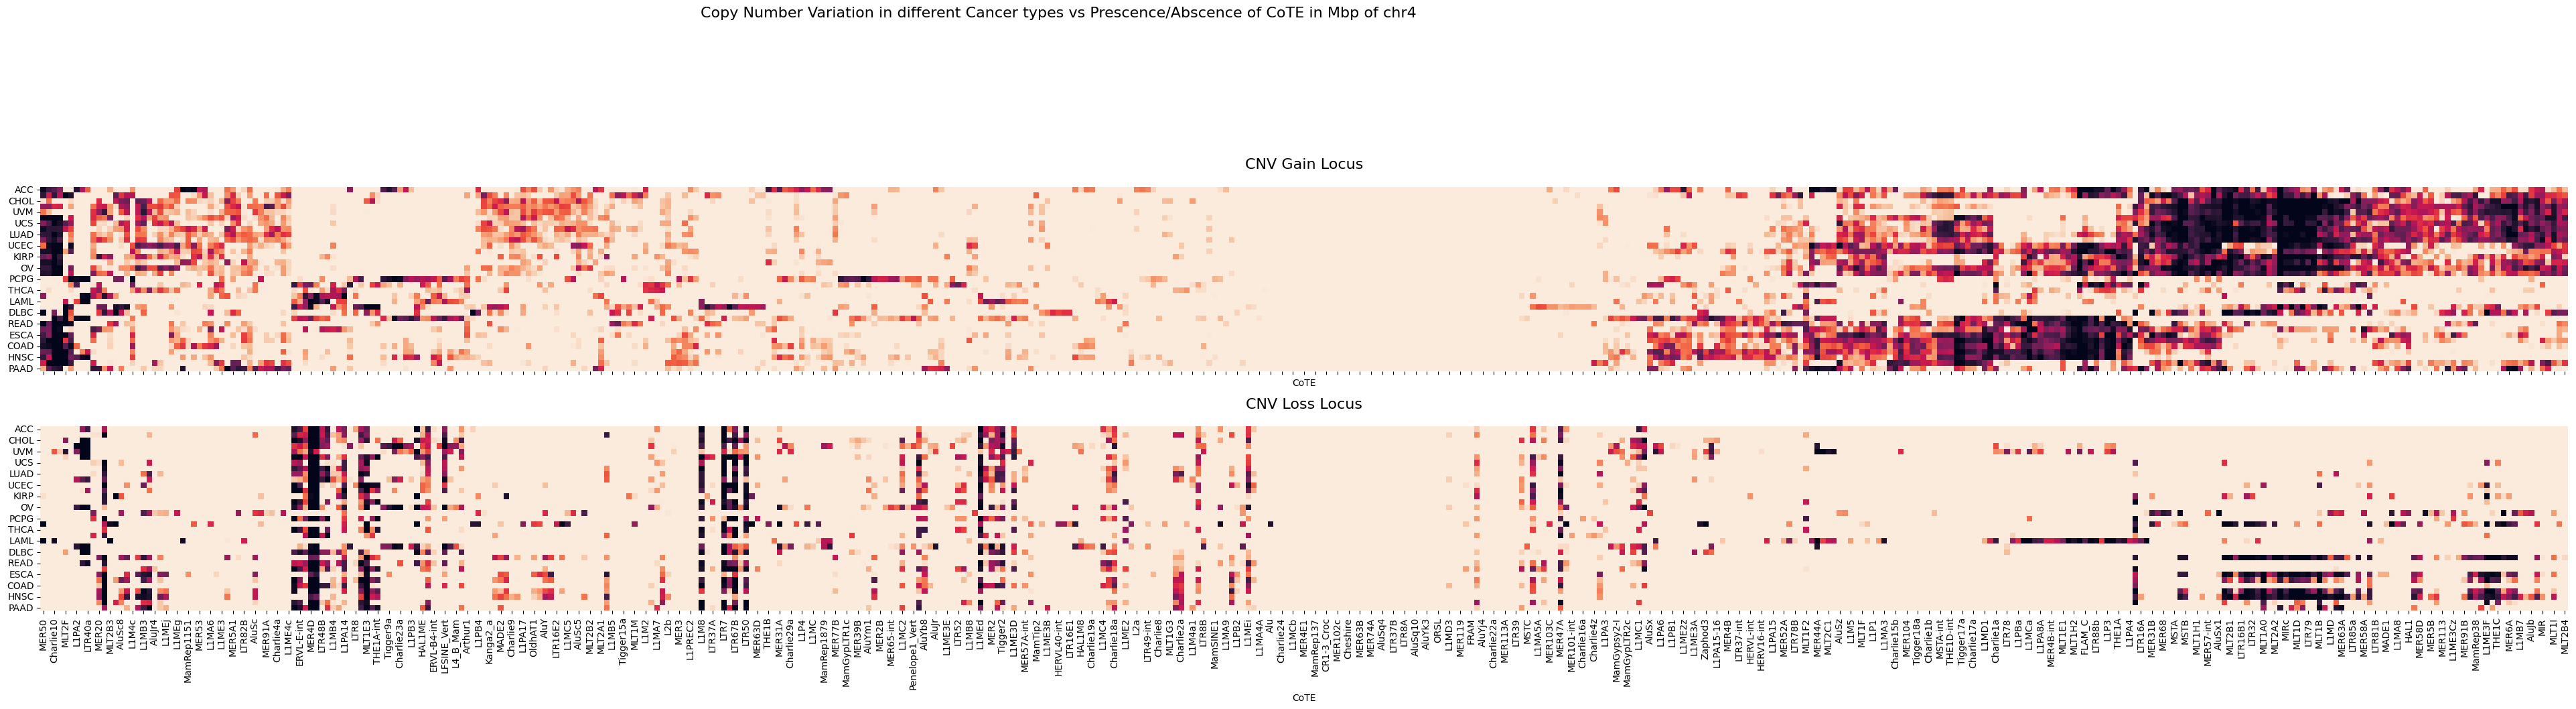

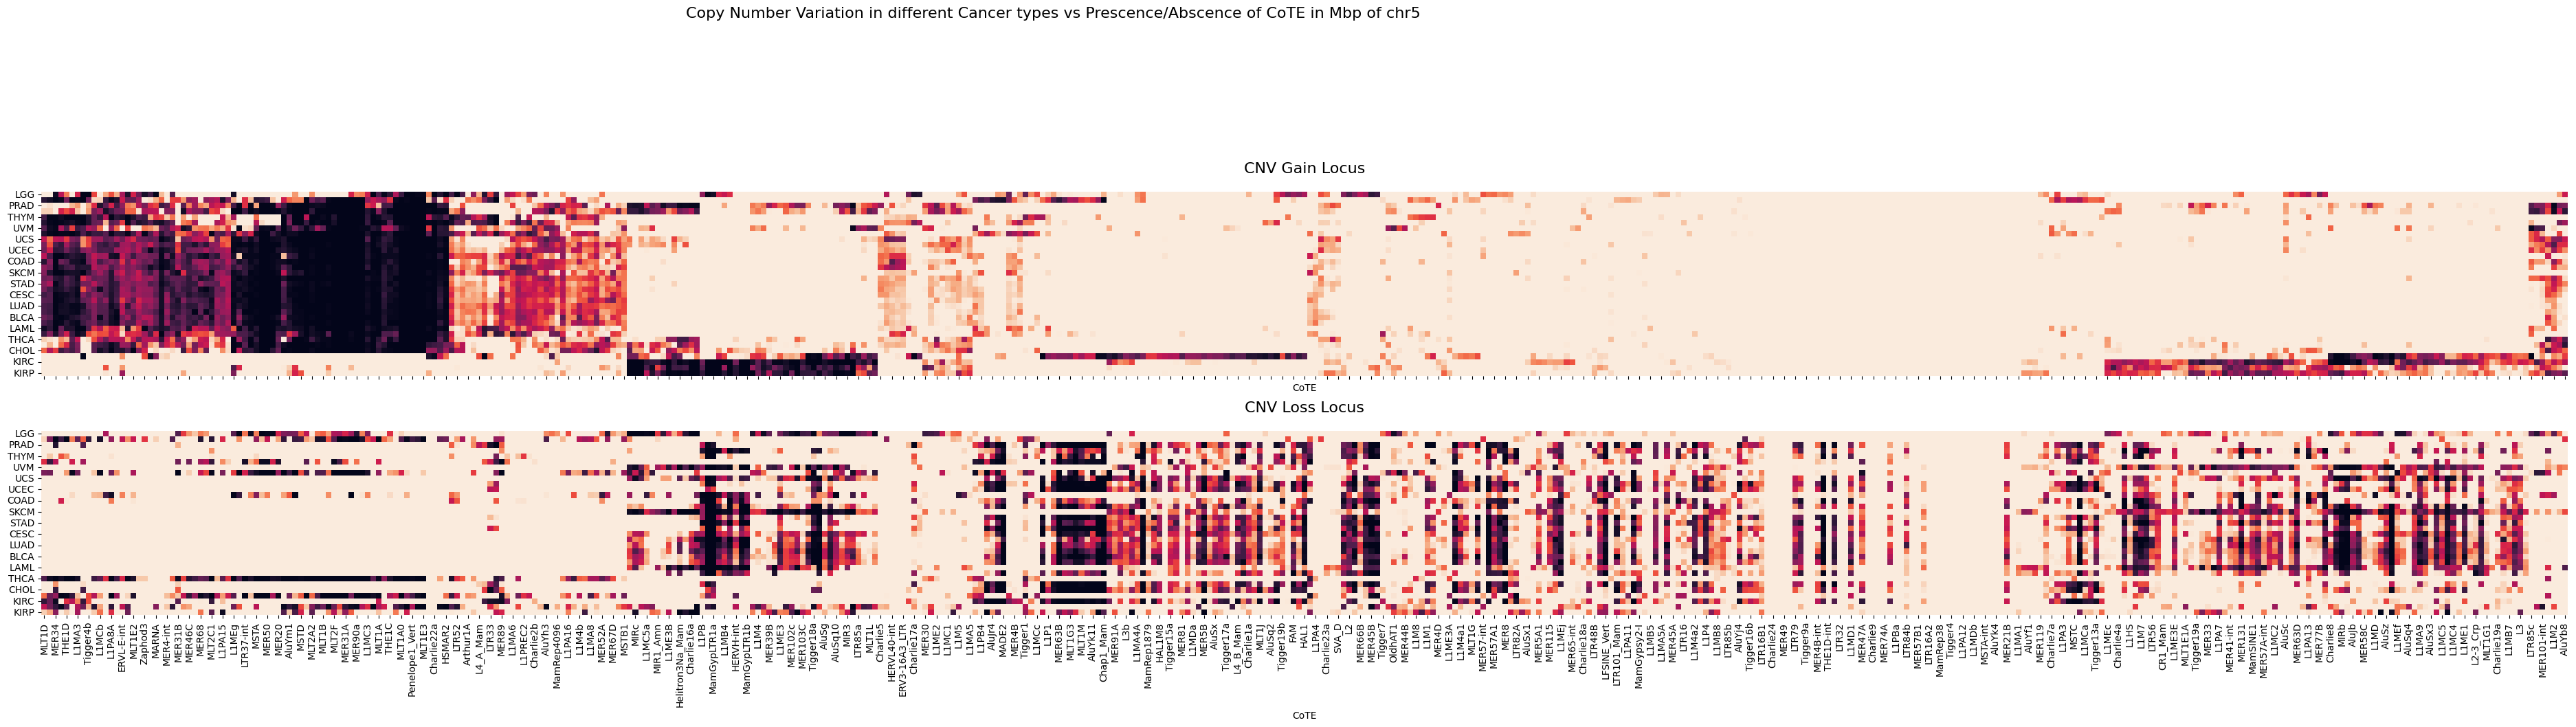

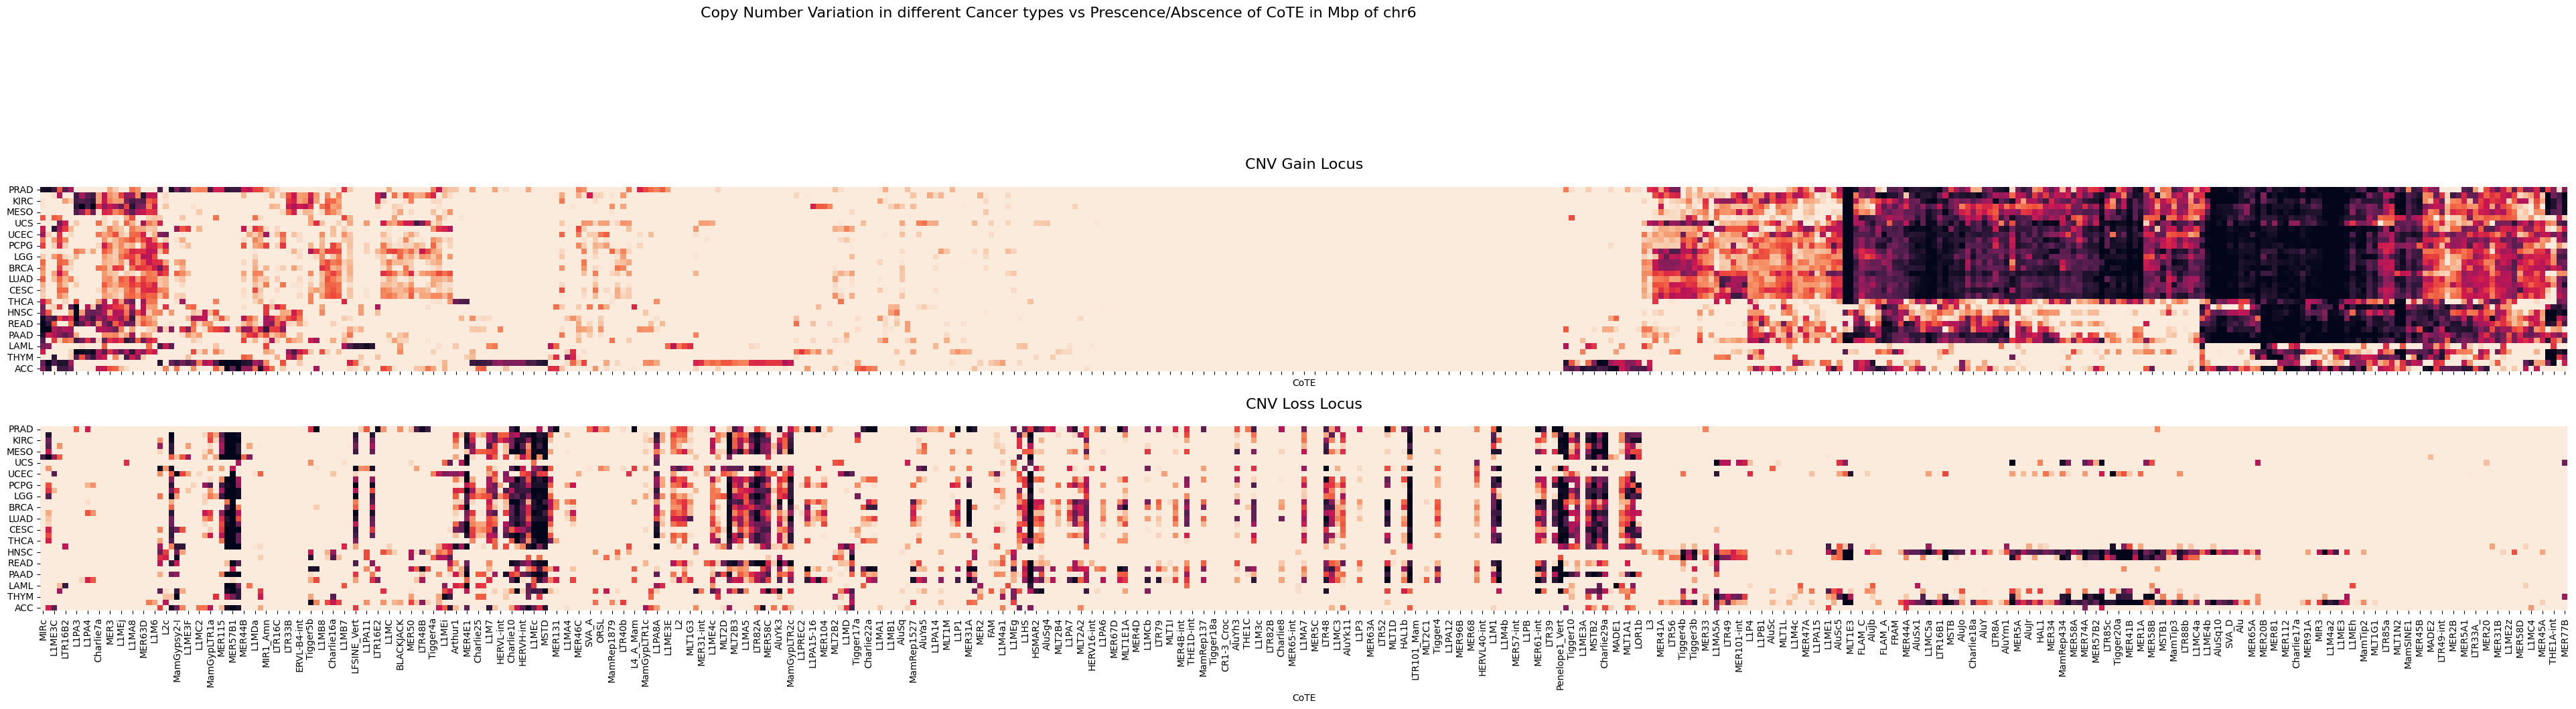

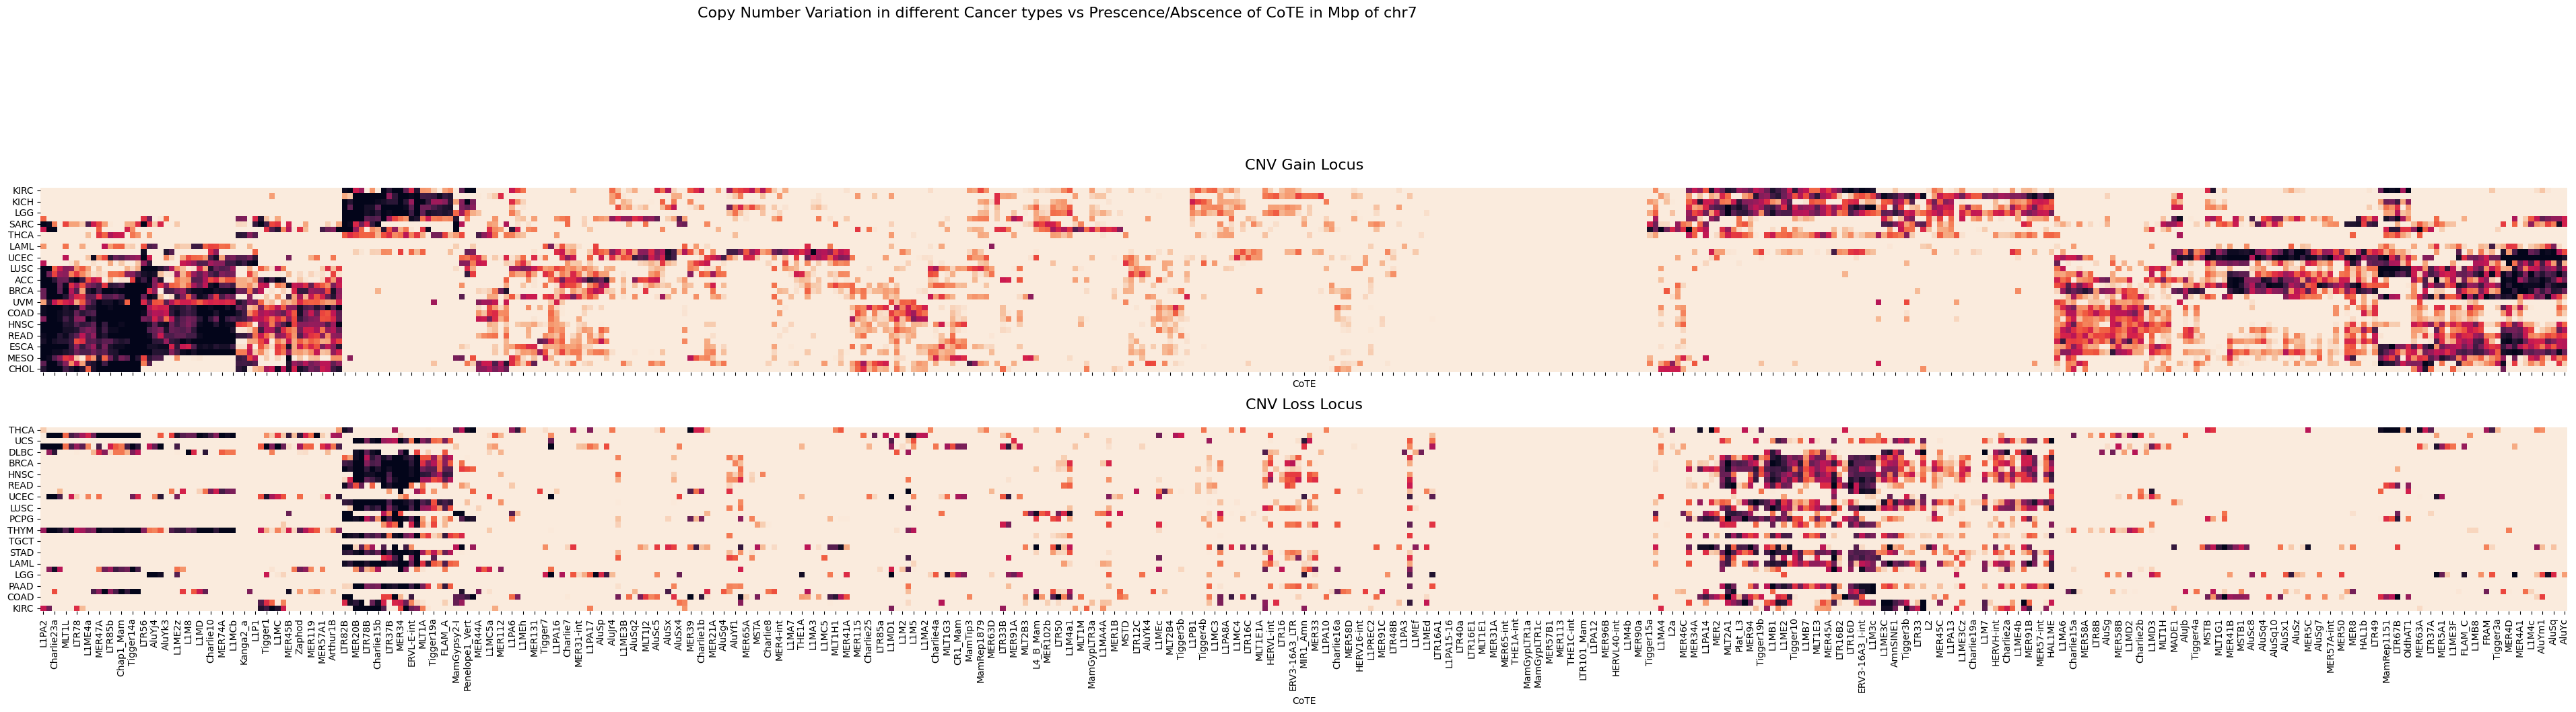

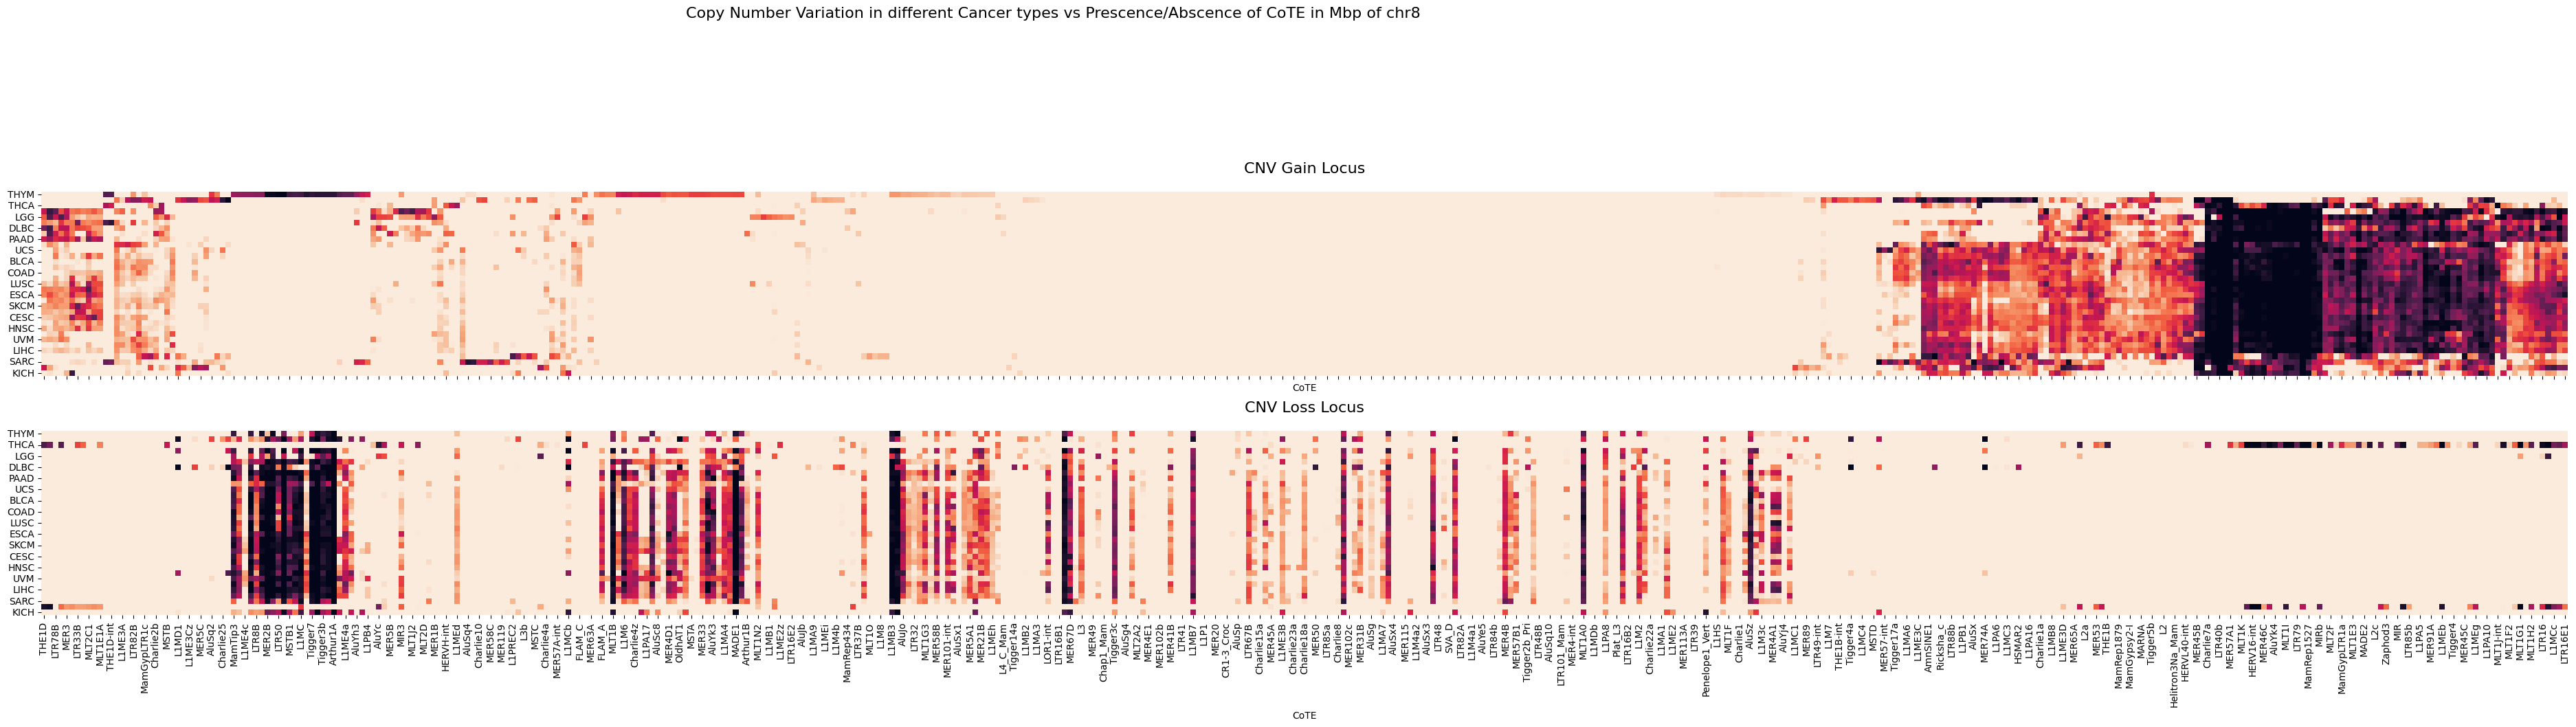

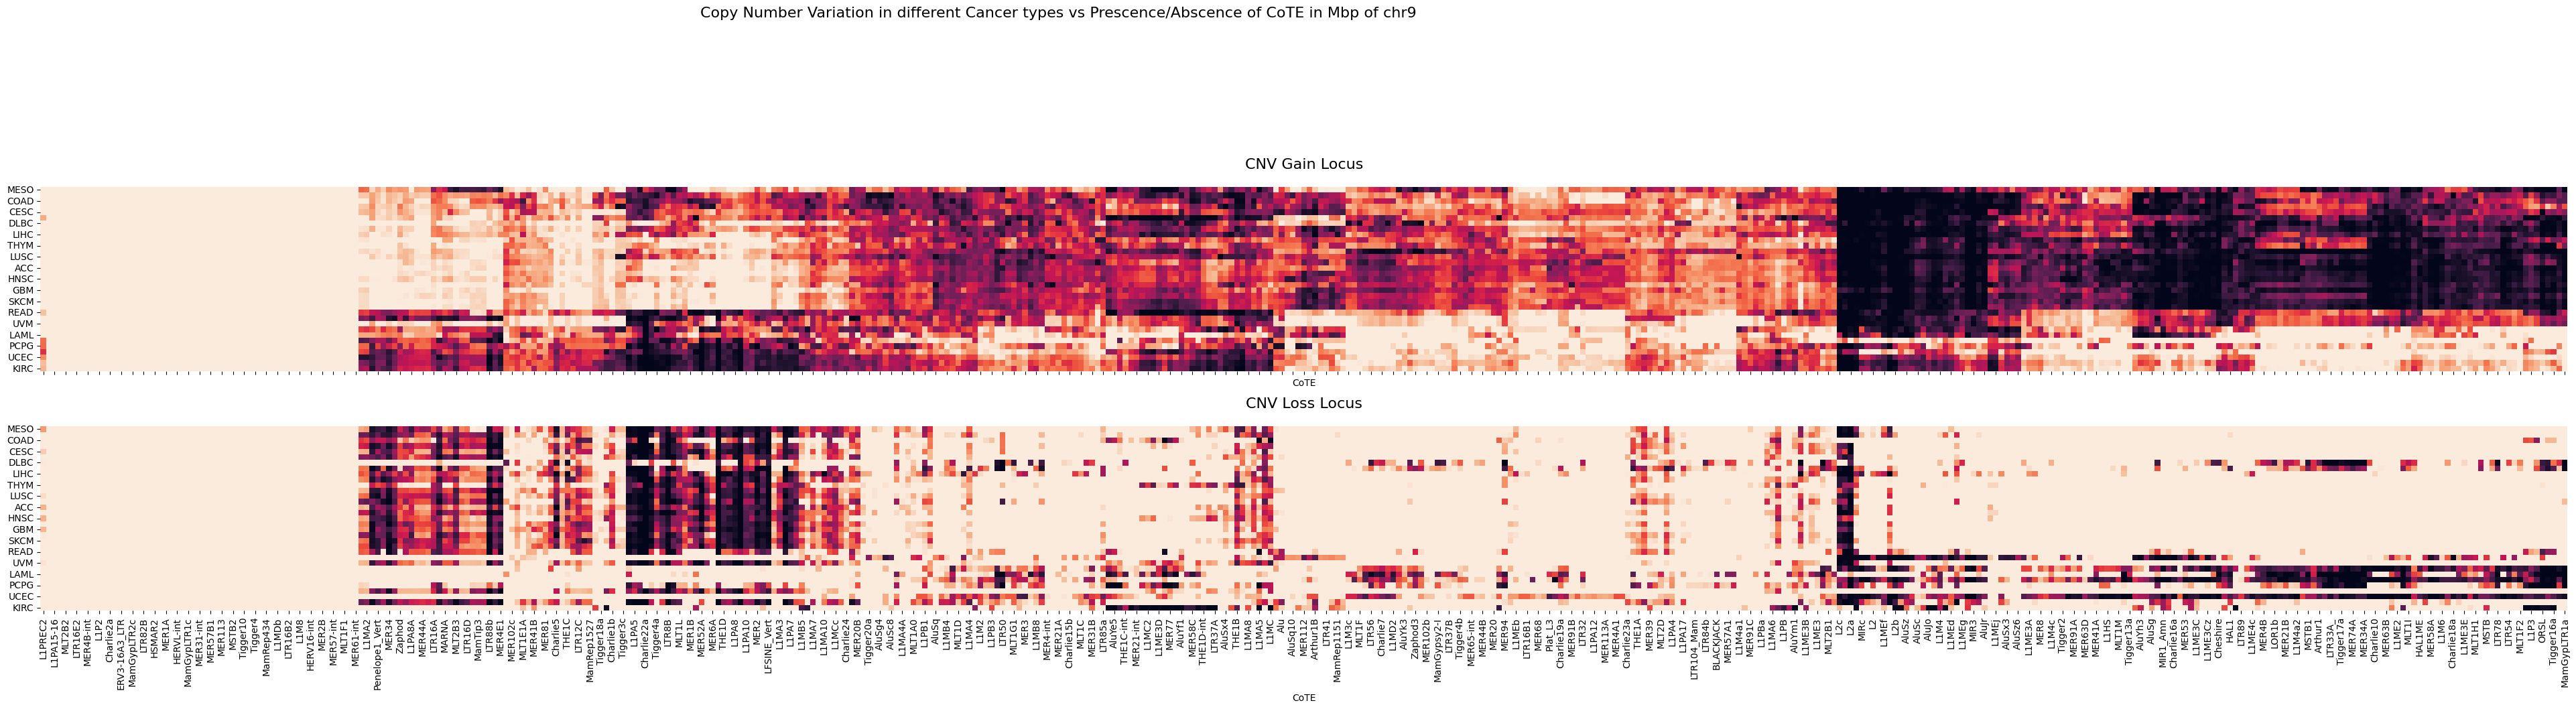

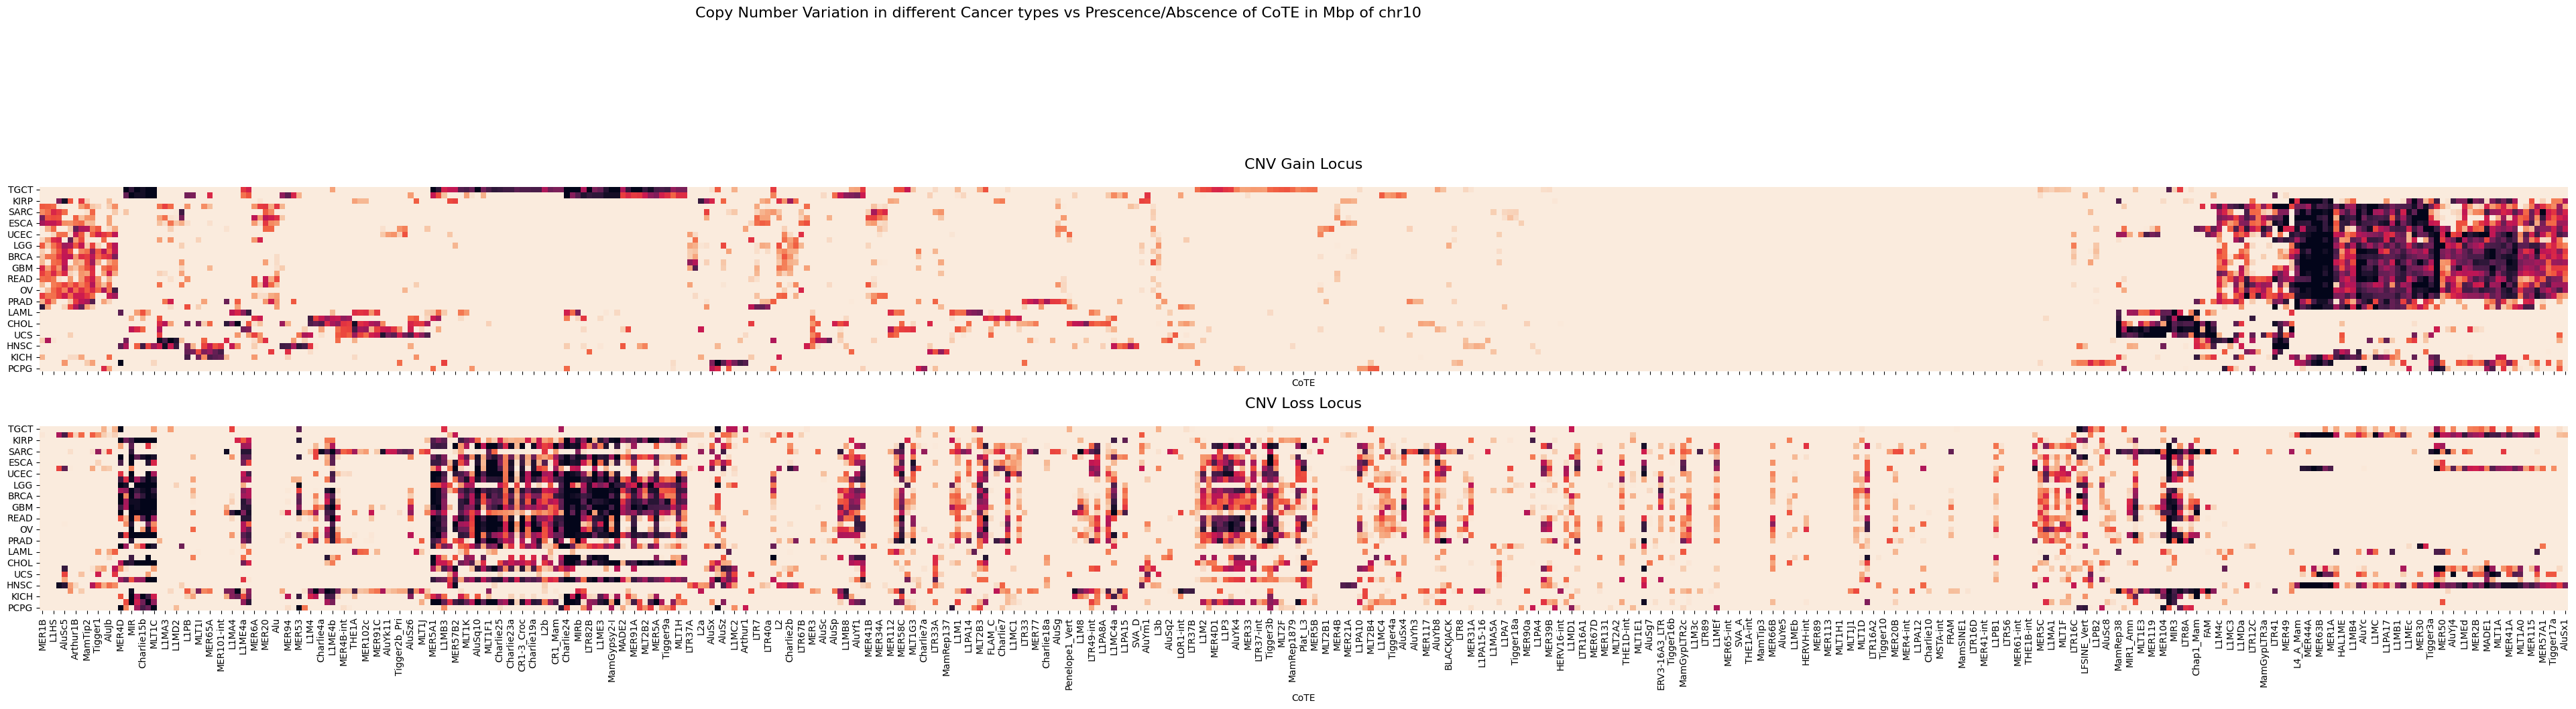

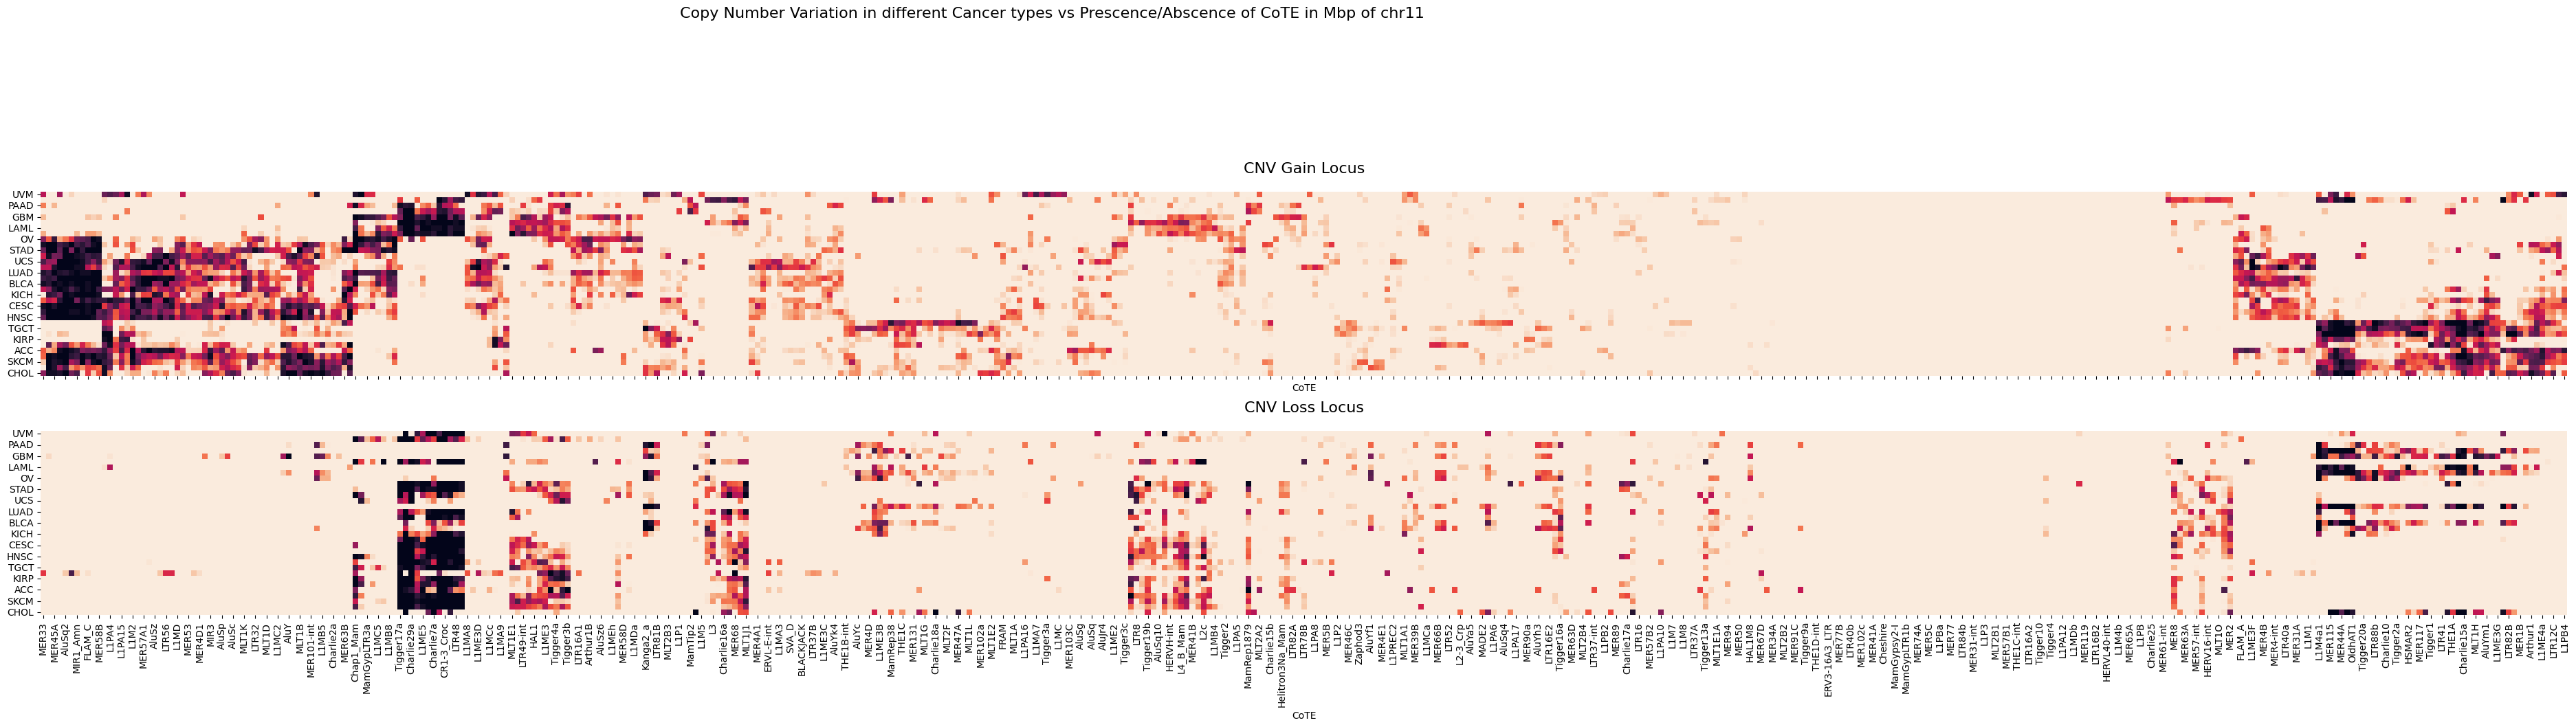

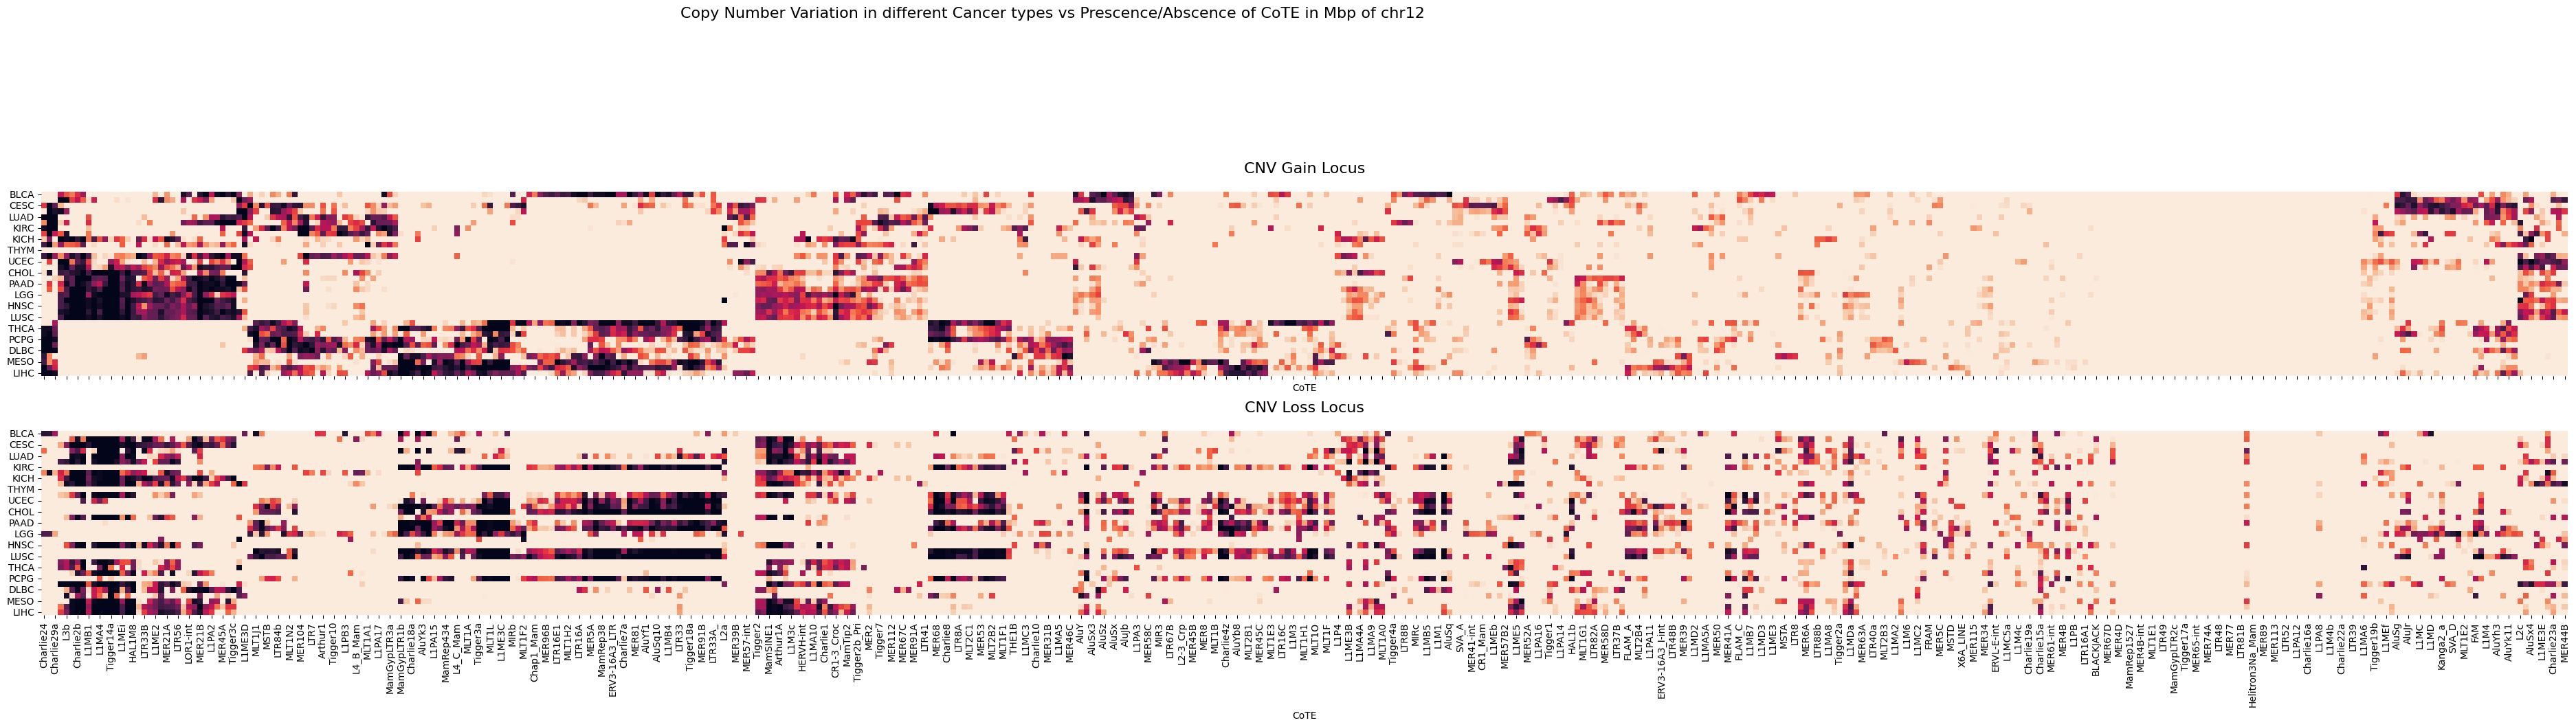

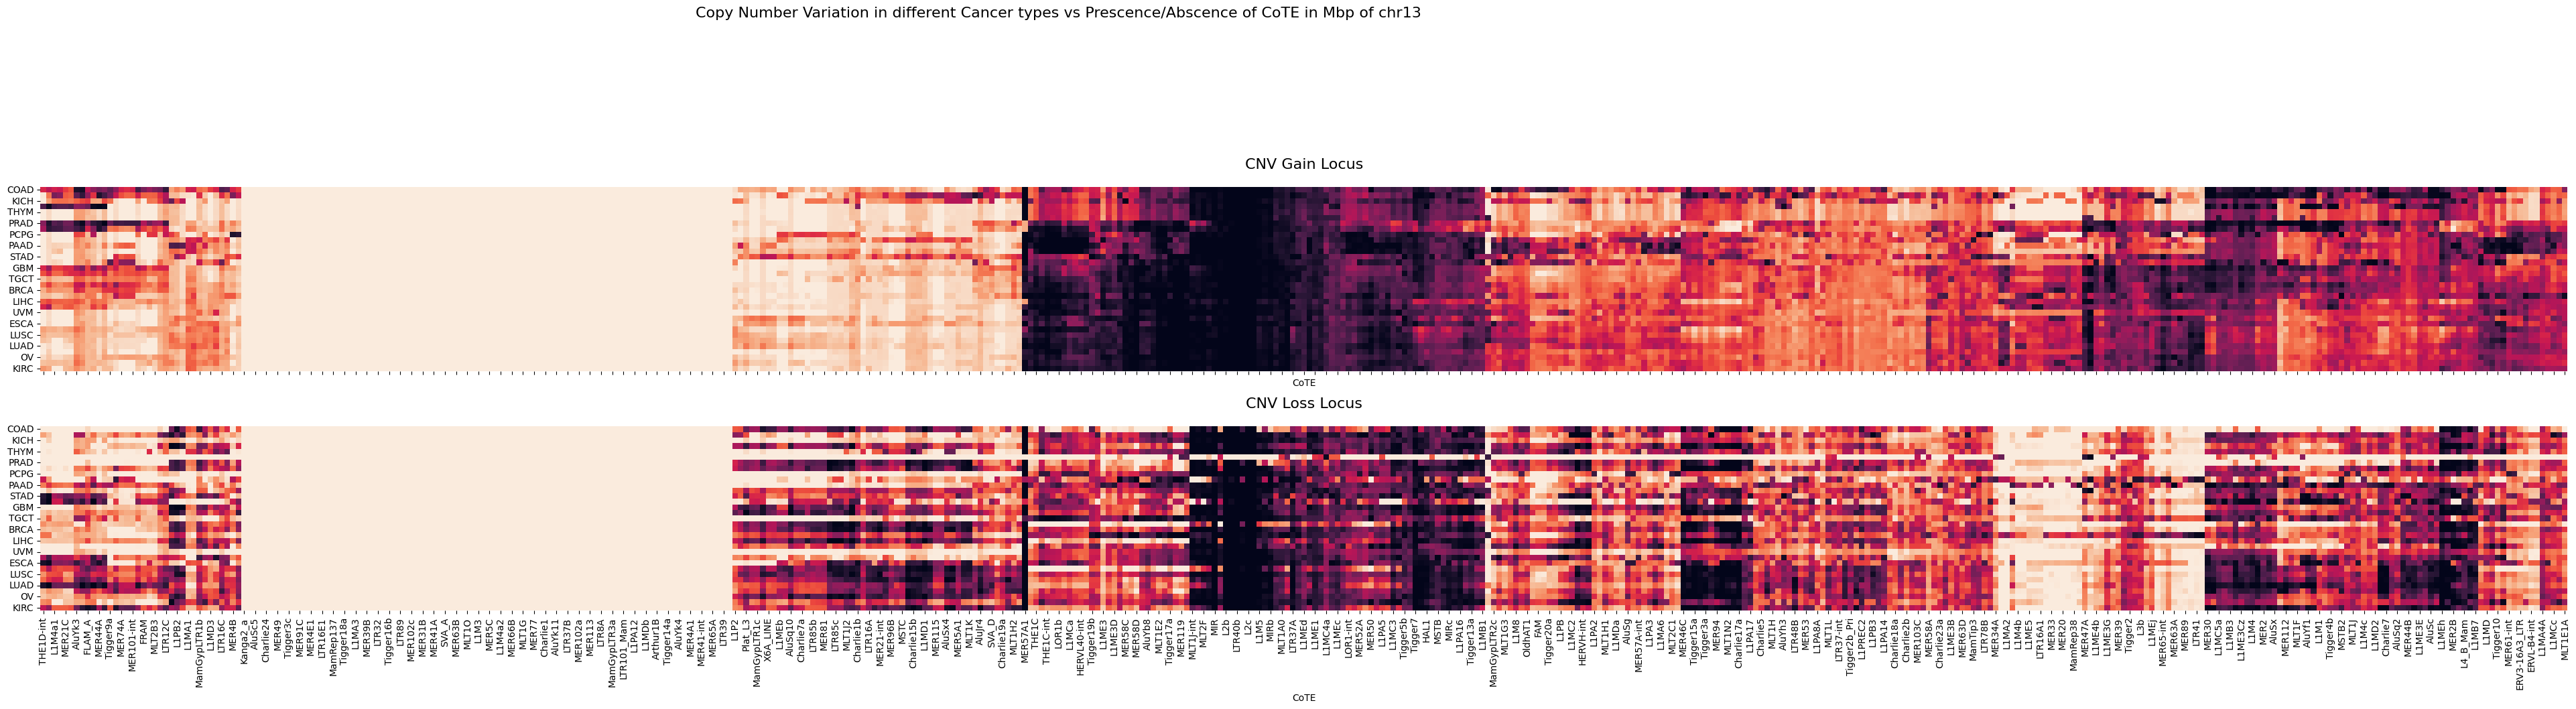

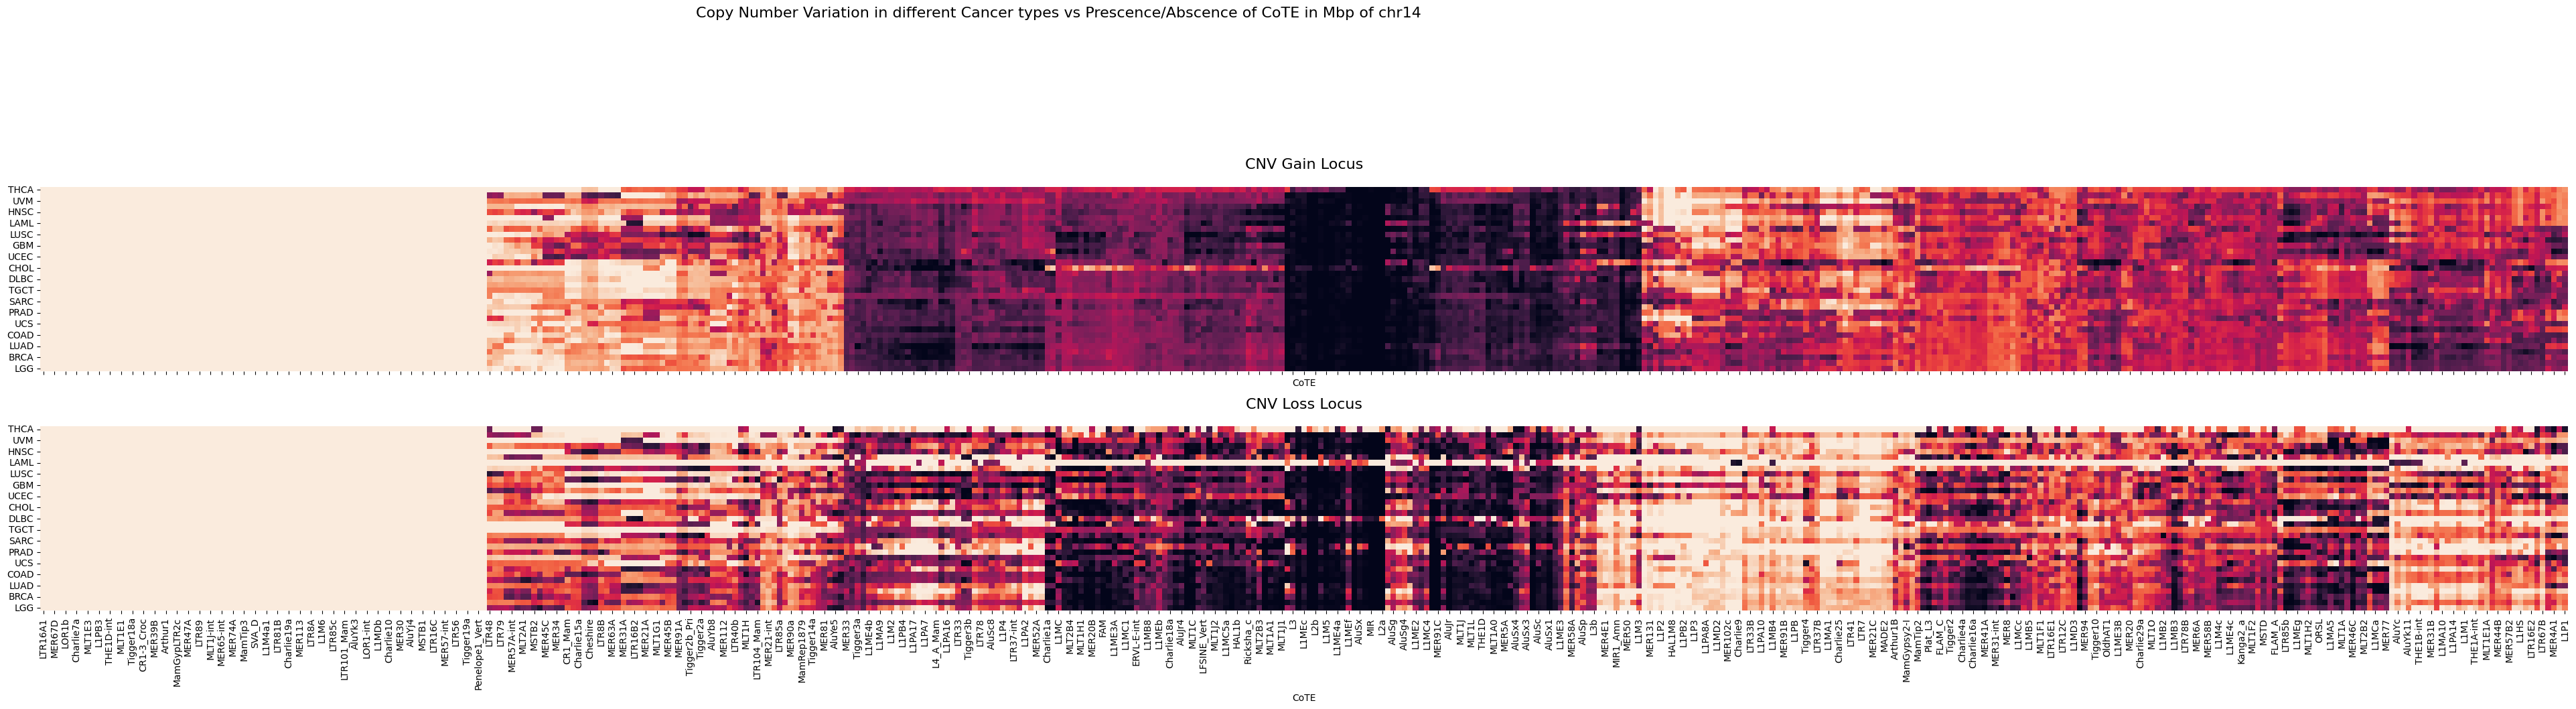

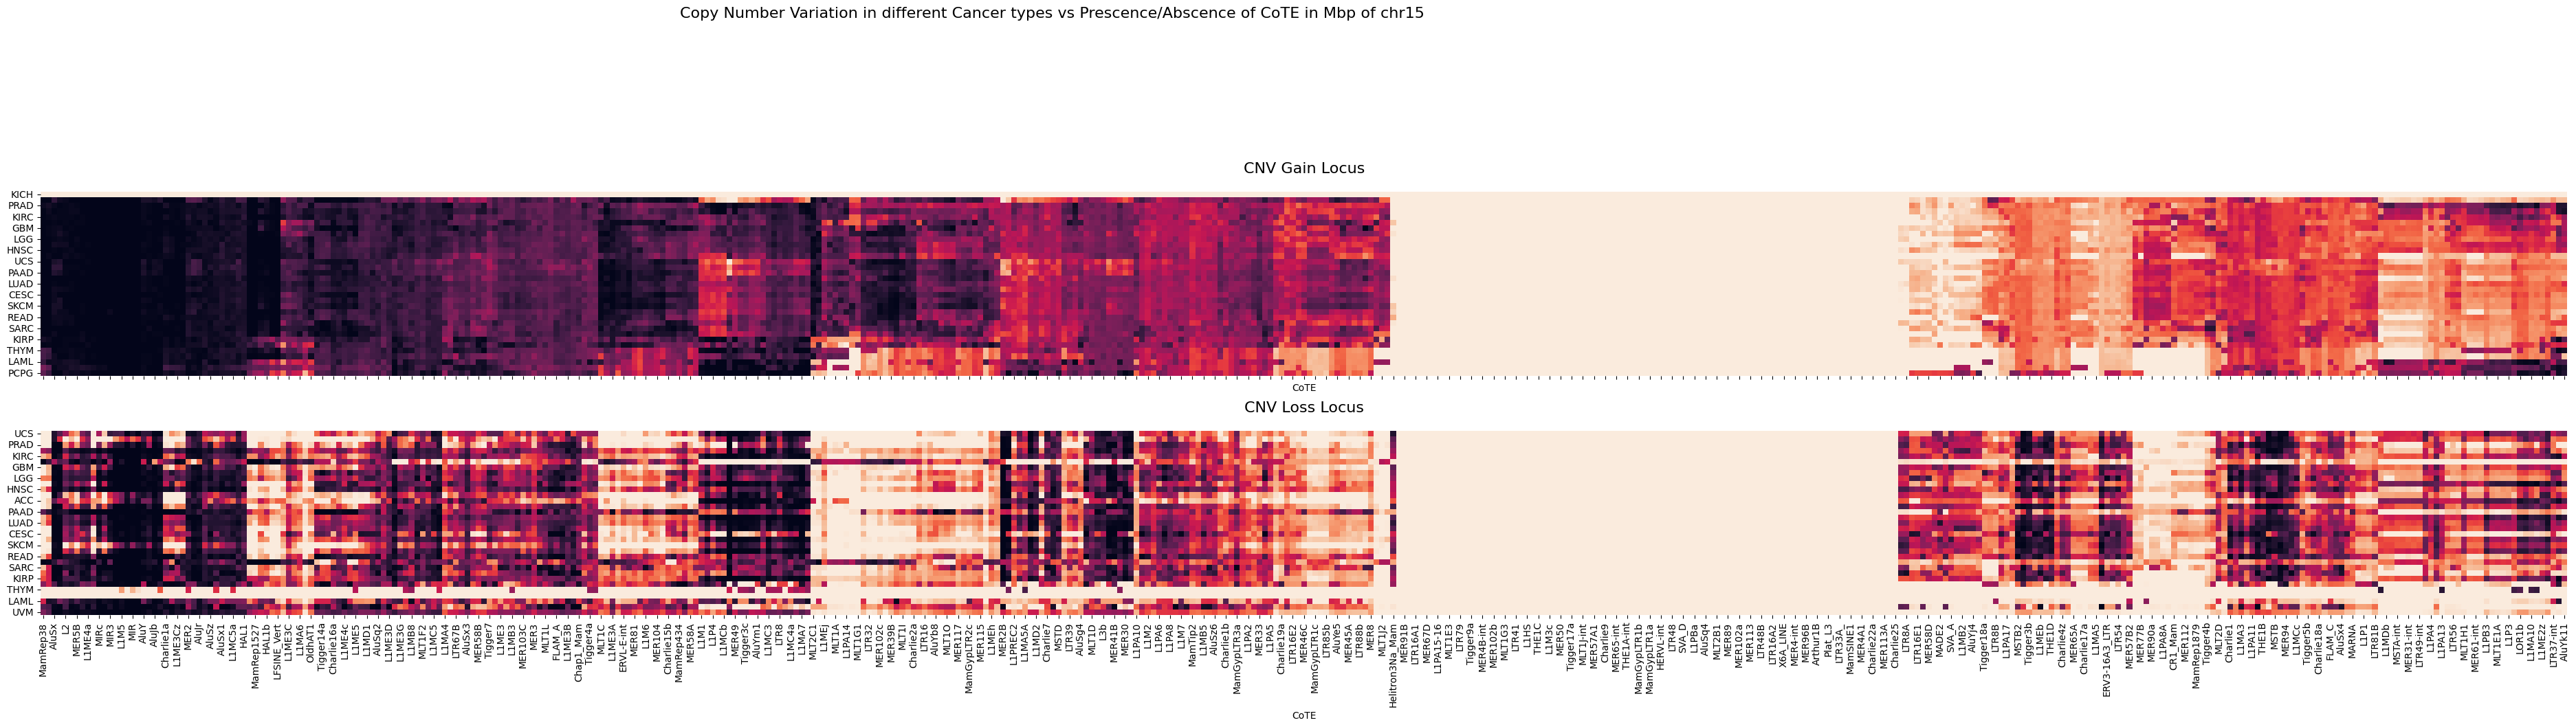

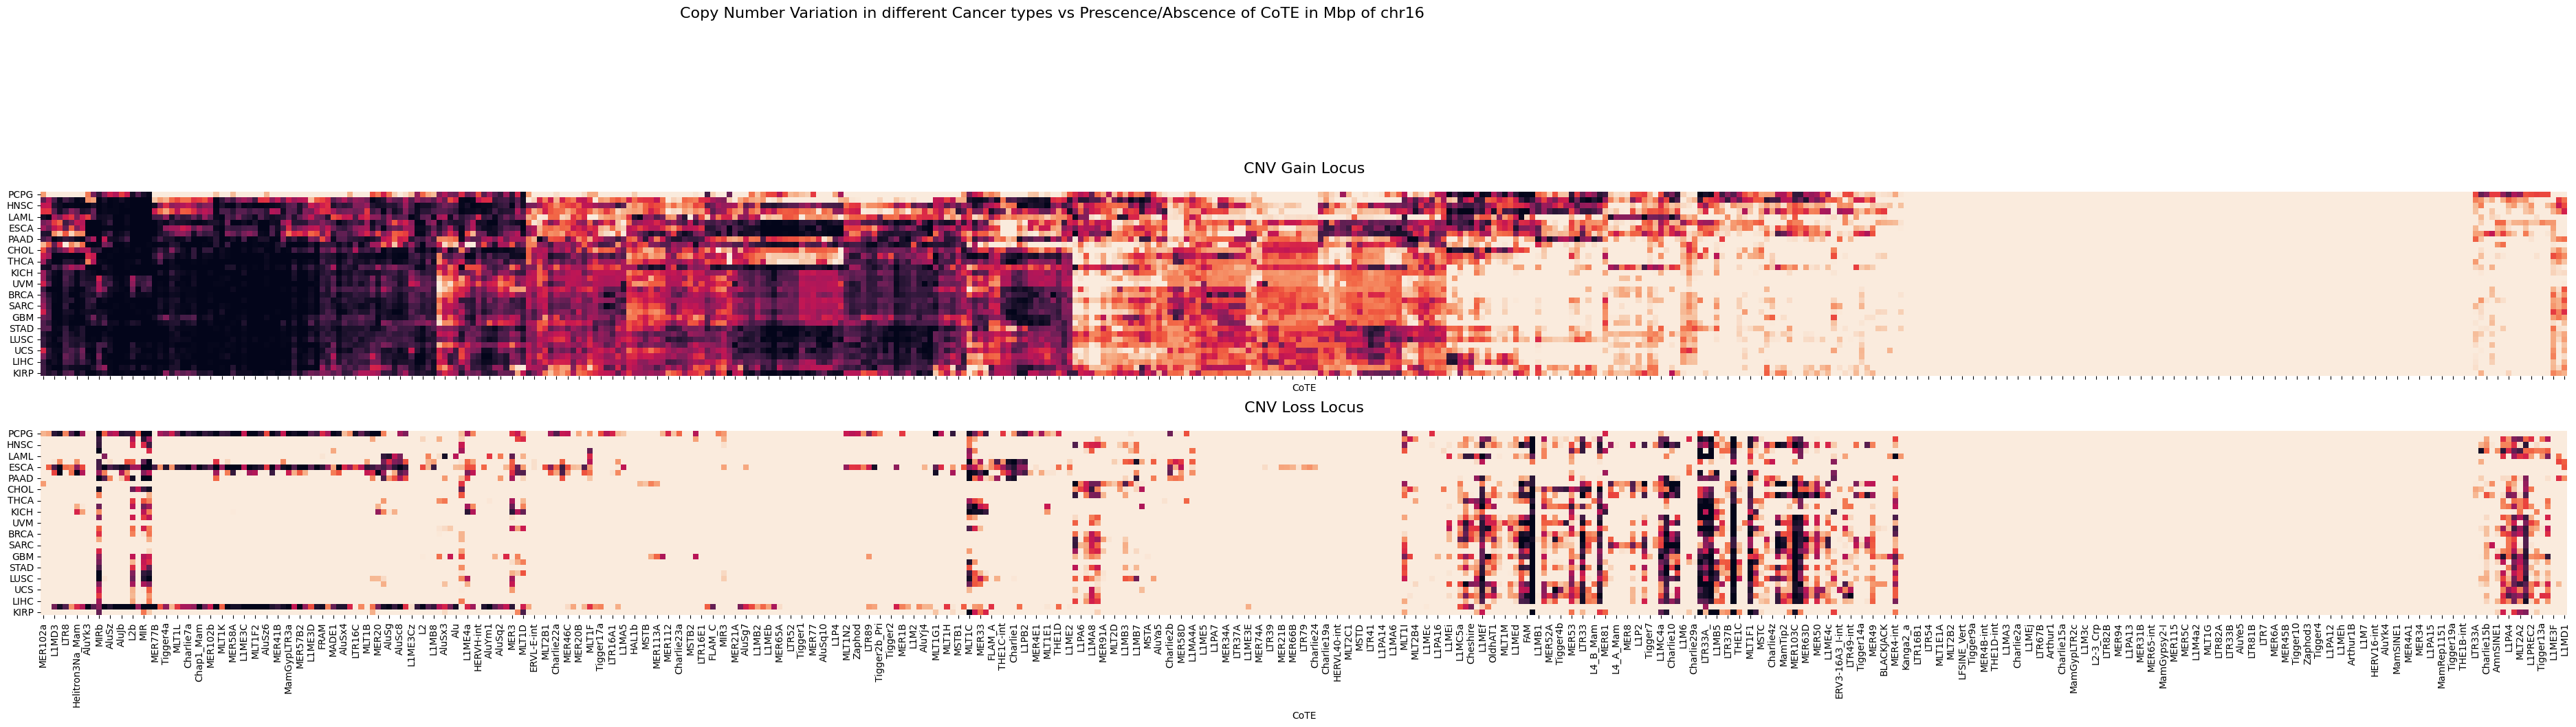

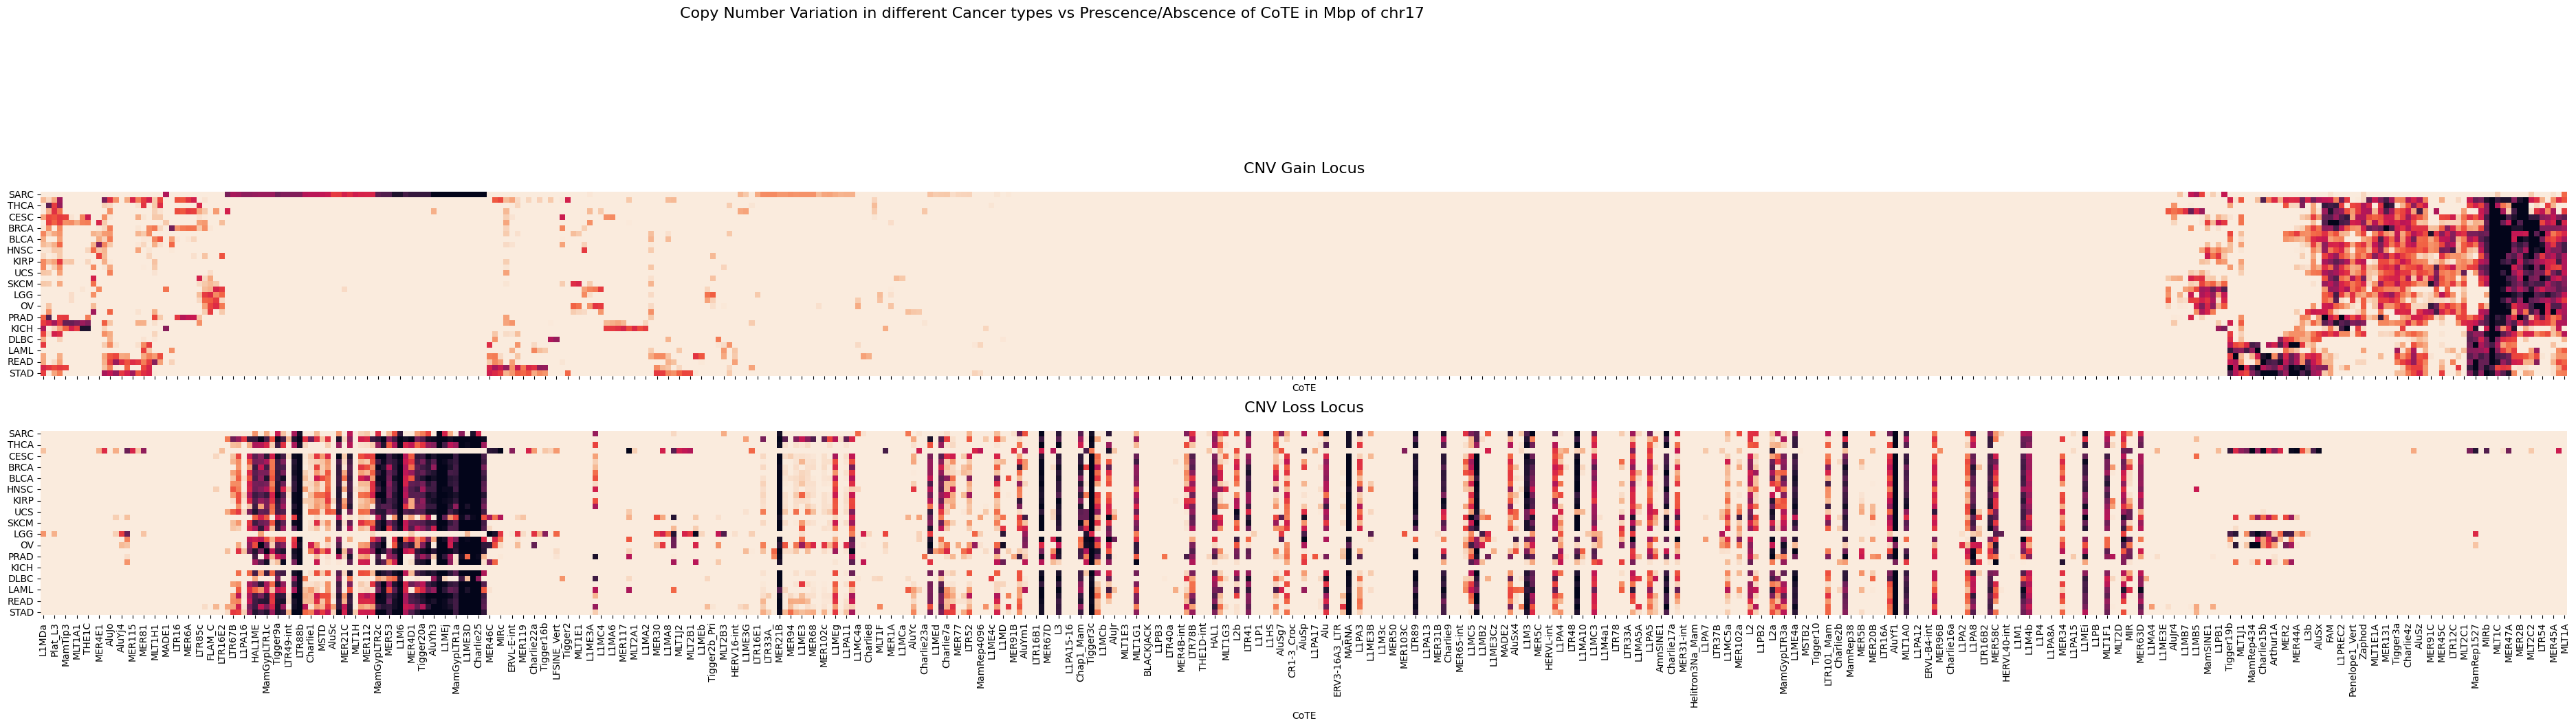

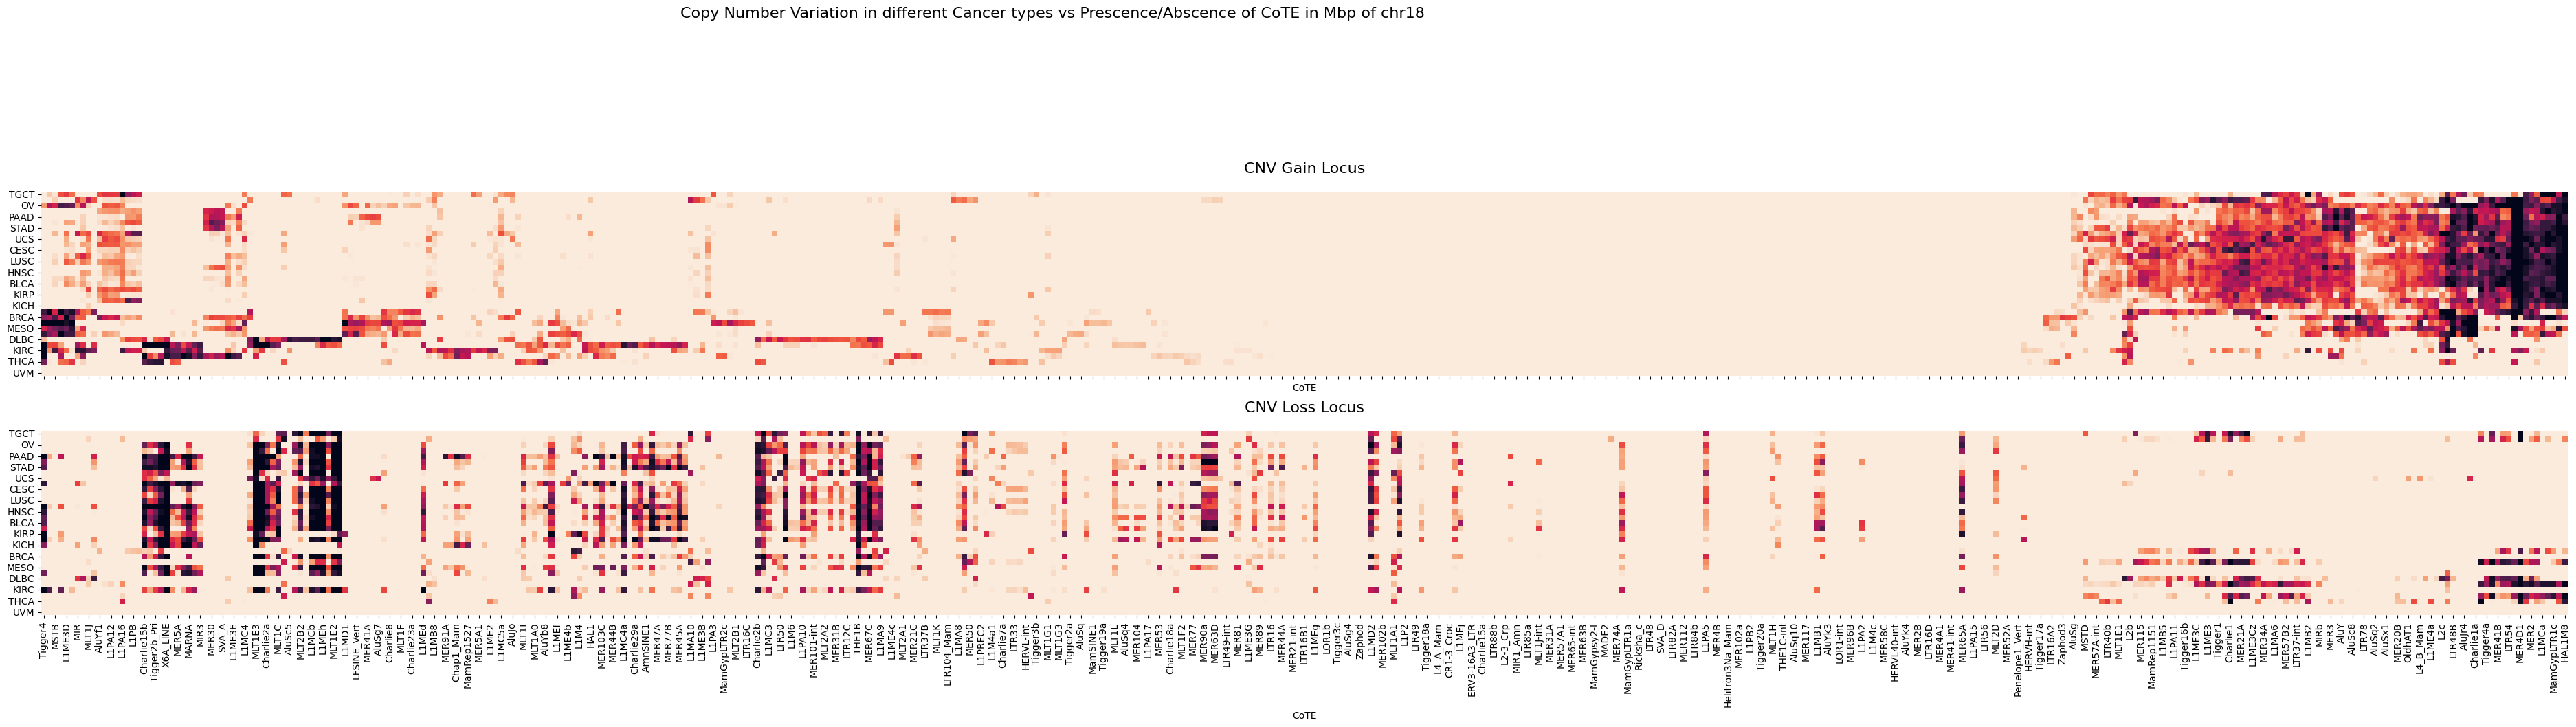

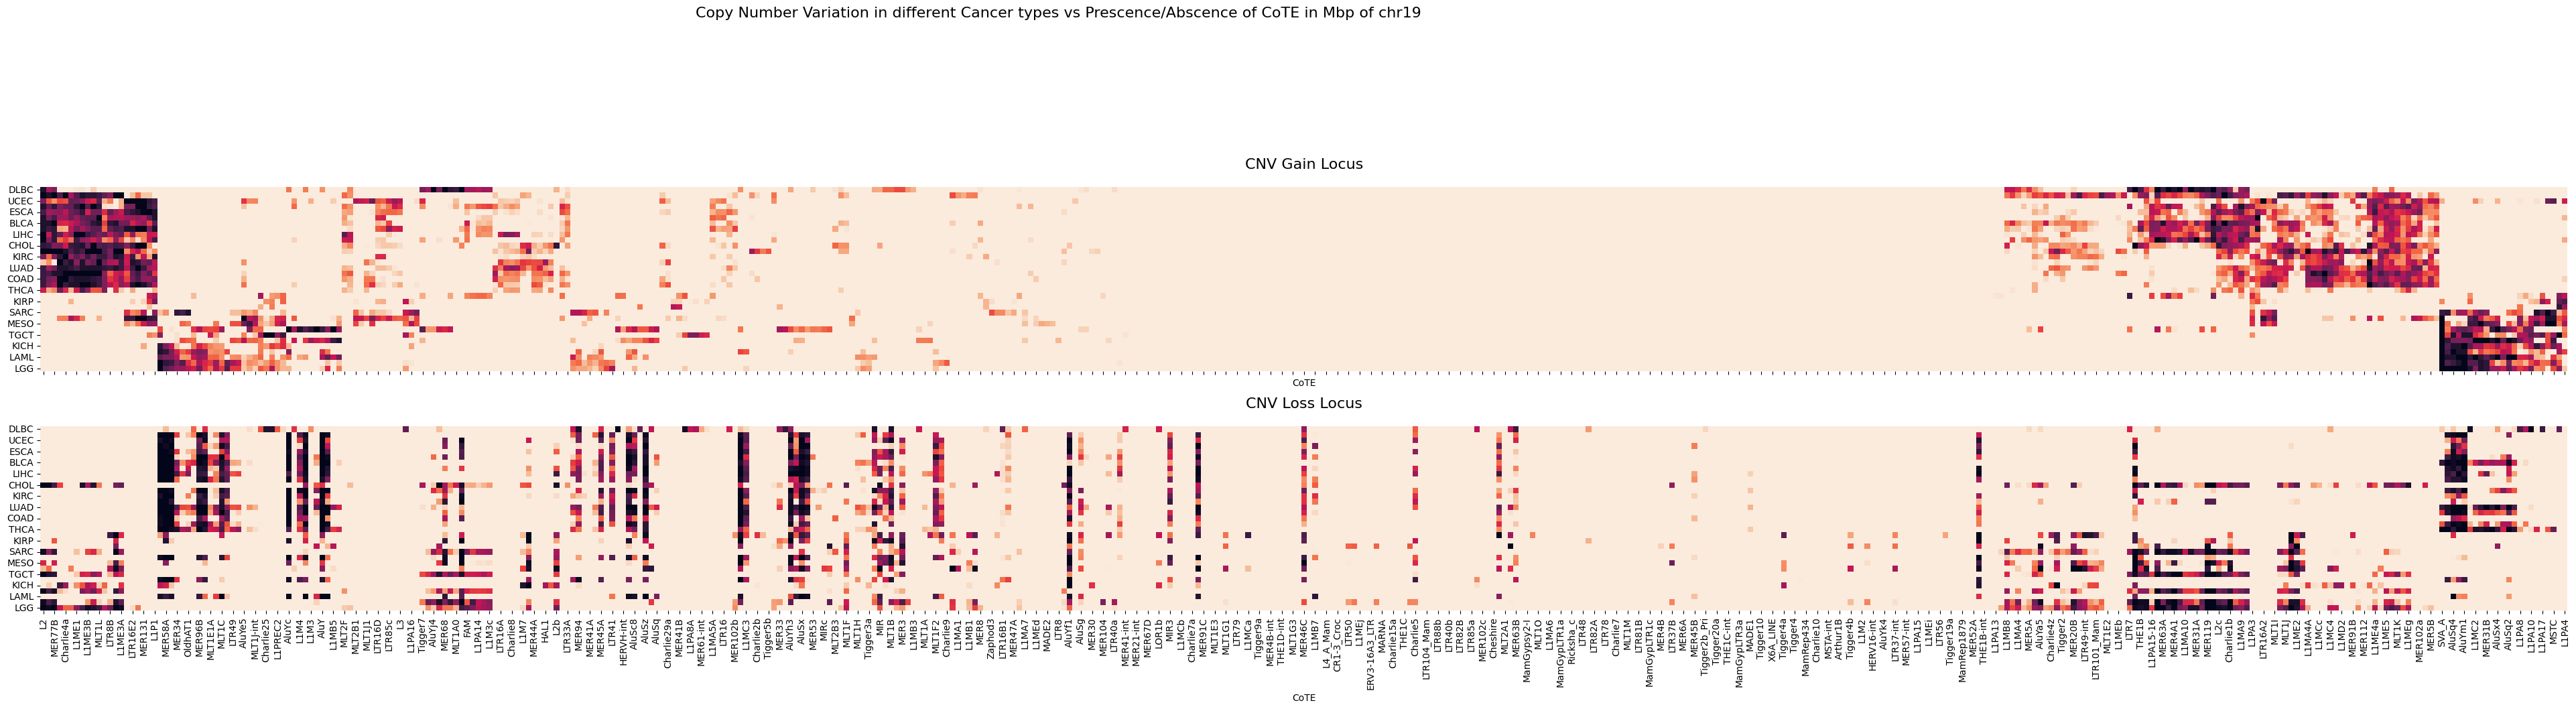

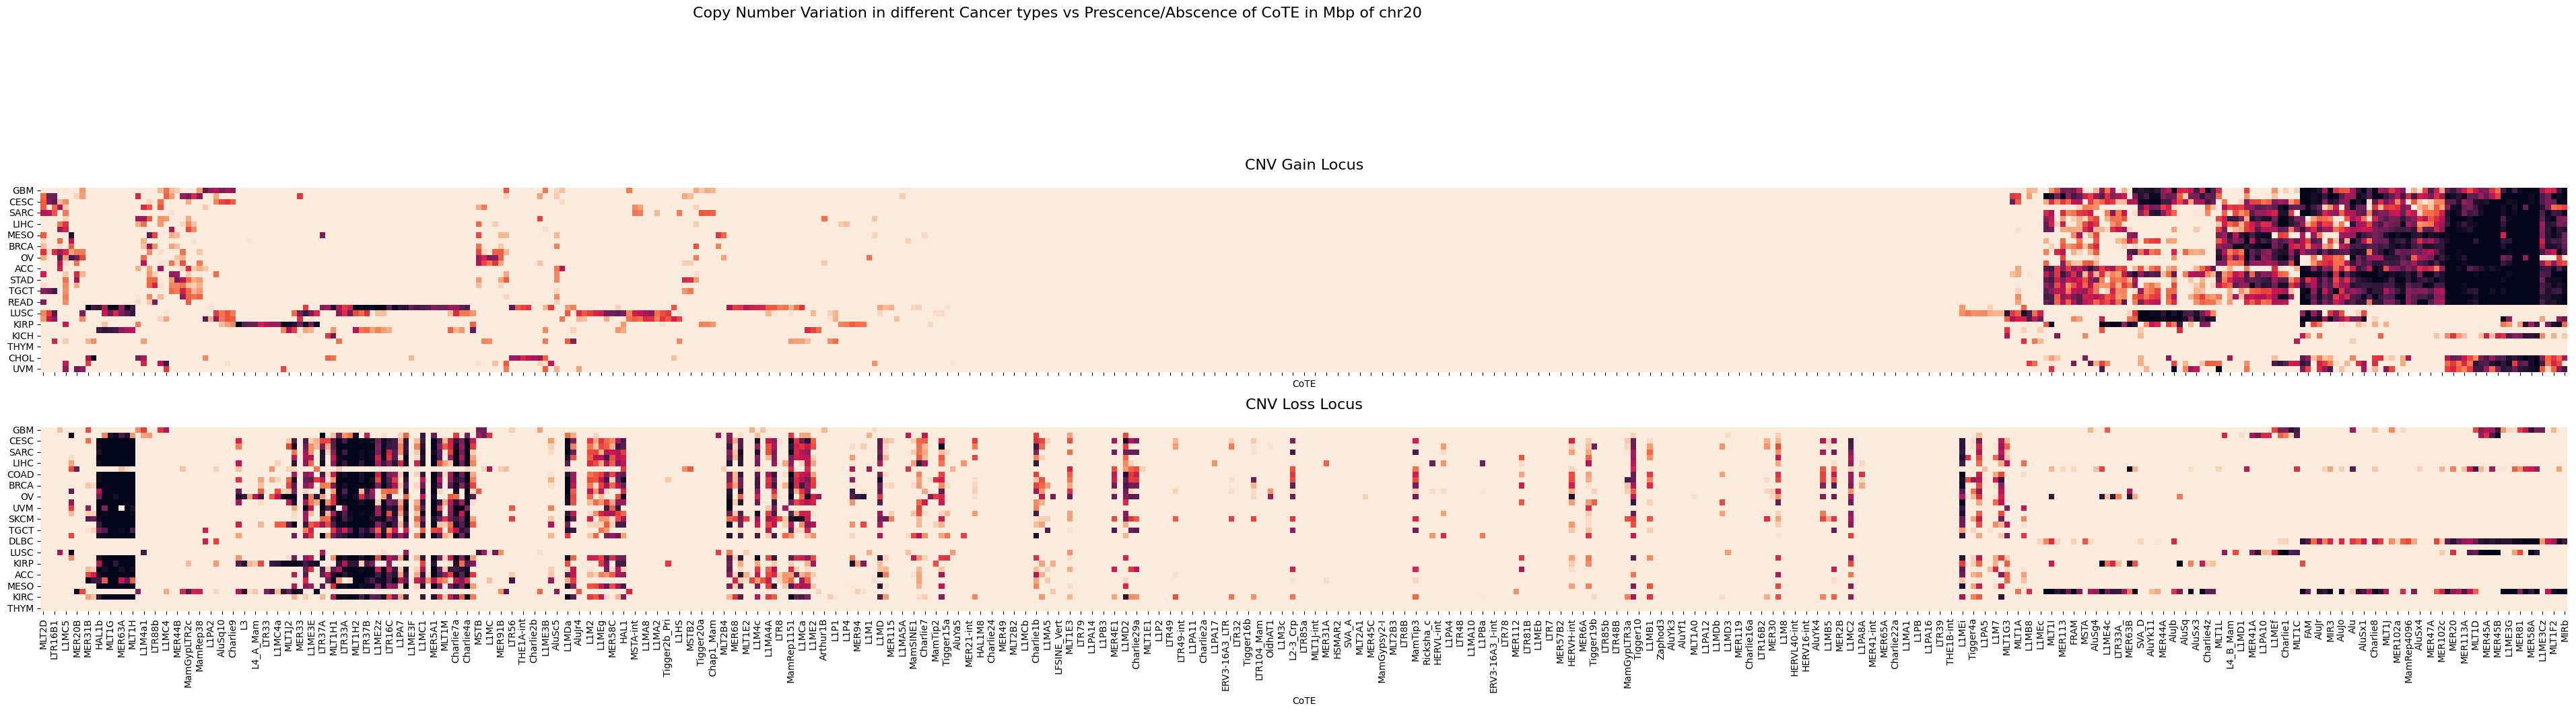

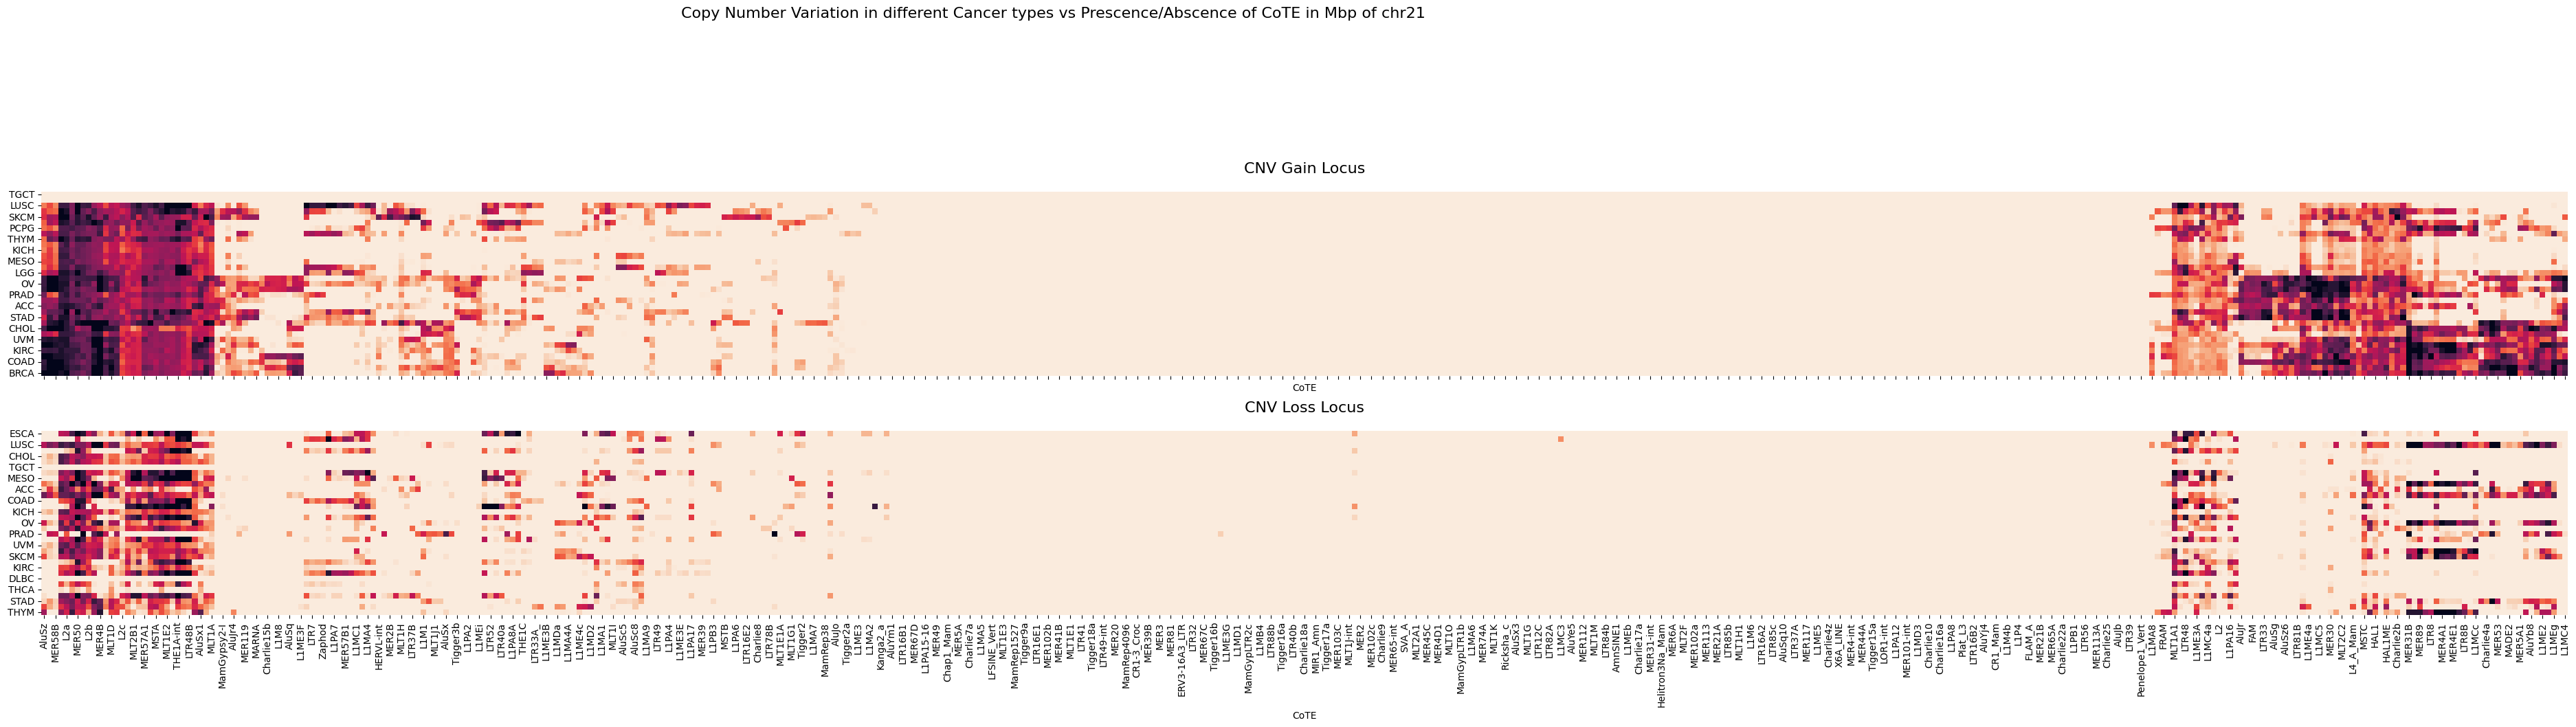

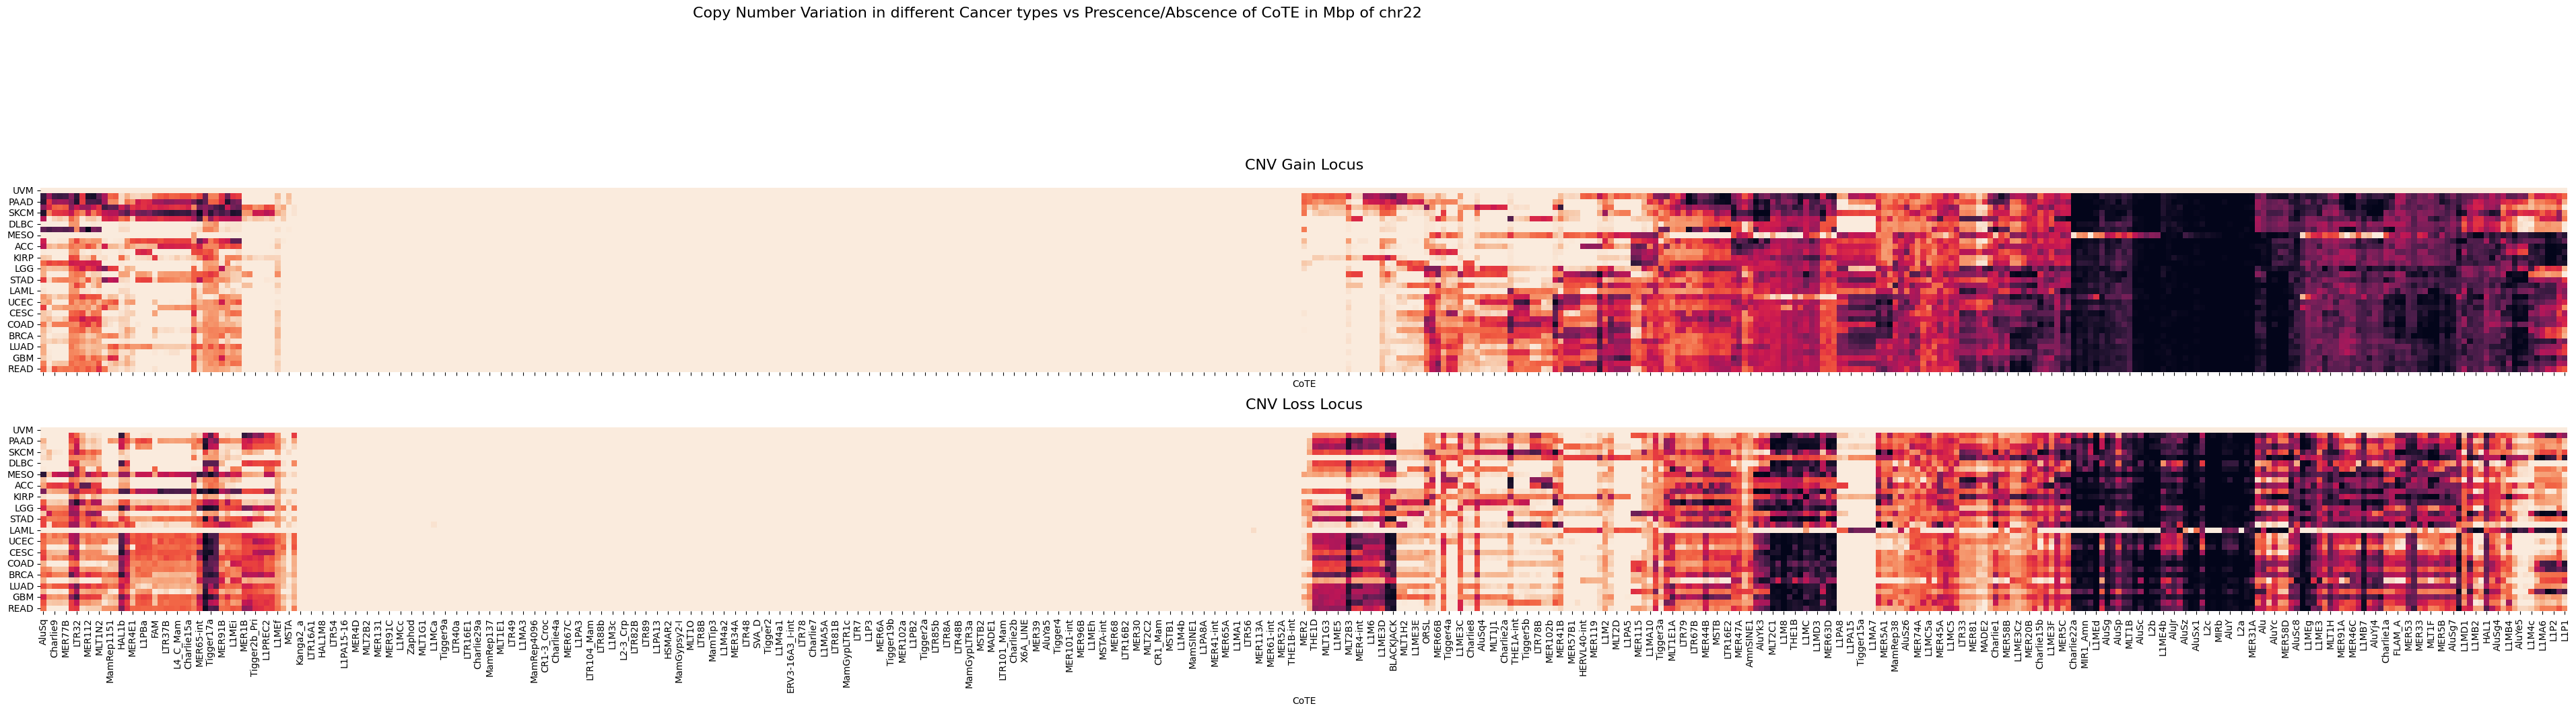

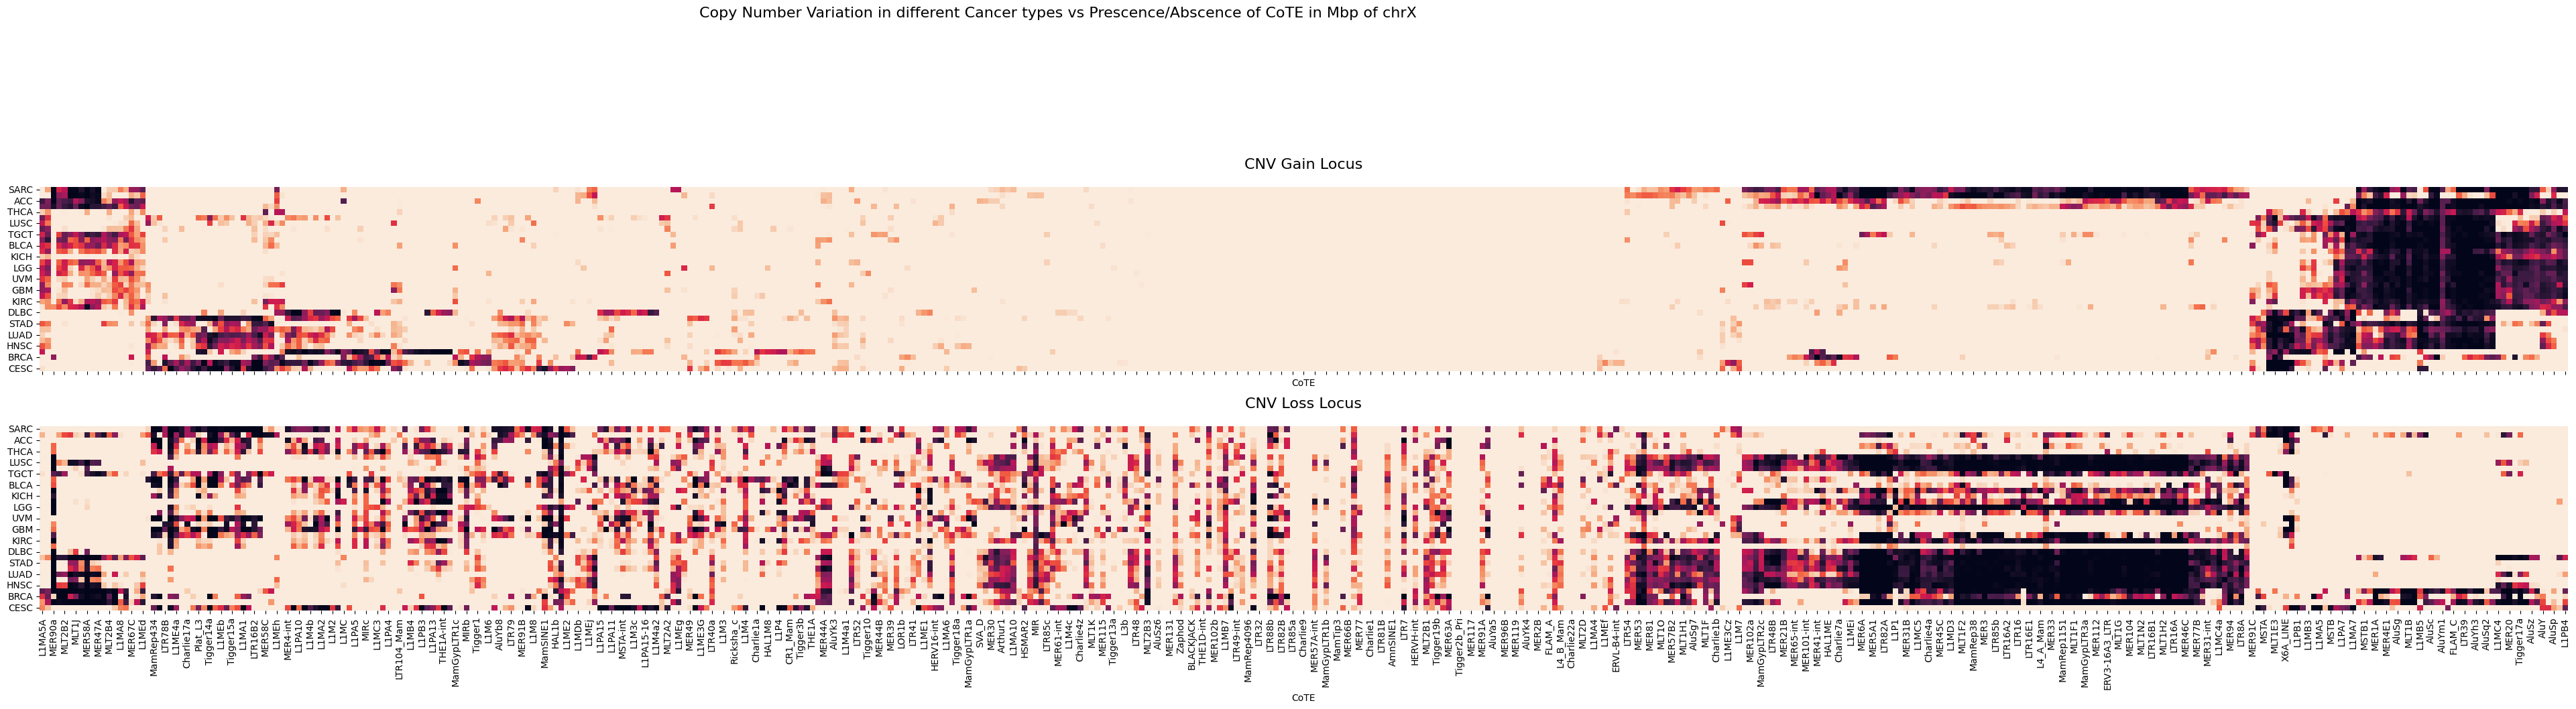

FileNotFoundError: [Errno 2] No such file or directory: '/cluster/home/t124771uhn/analysis/experiment10/gain/chrY__qval_n_hit.csv'

In [223]:
for c in chroms[:-1]:
    lg_heatmap(c=c)

In [107]:
import h5py
import csv
def flatten_h5_to_csv(input_path, output_dir):
    # Extract the base name without extension
    base_name = os.path.basename(input_path)
    base_name_without_ext = os.path.splitext(base_name)[0]
    
    # Define the CSV output path
    csv_output_path = os.path.join(output_dir, base_name_without_ext + '.csv')
    
    # Load the .h5 file and read the data
    with h5py.File(input_path, 'r') as file:
        # Assuming the dataset is the first key
        dataset_name = list(file.keys())[0]
        data = file[dataset_name][:]
        
        # Flatten the entire 3D array into a 1D array and convert it to a list
        flattened_data = data.flatten().tolist()
        # Prepend the dimensions (depth, rows, columns) to the list
        data_with_dims = [data.shape[0], data.shape[1], data.shape[2]] + flattened_data
        
        # Open a new CSV file for writing the 1D array
        with open(csv_output_path, mode='w', newline='') as csv_file:
            writer = csv.writer(csv_file)
            # Write the 1D array as a single row in the CSV file
            writer.writerow(data_with_dims)

In [110]:
path = '/cluster/home/t124771uhn/analysis/experiment11/loss/hits/'
files = os.listdir(path)
for f in files:
    p = os.path.join(path, f)
    flatten_h5_to_csv(p, '/cluster/home/t124771uhn/loss_hits/')